# Configuration

NOTES: The warnings after the import are referred to the fact that Tensorflow 2.x versions are built to directly look for a GPU in the system. The warning can be forgot if you are not going to use the GPU. 

In [2]:
!source myenv/bin/activate

In [3]:
# samples in 5 seconds of audio, 16 KHz sample rate 
LENGTH_CHOSEN =  80000

In [4]:
import os
import librosa
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('whitegrid')
import IPython.display as ipd
import librosa.display
import numpy as np
import pickle
import scipy
import ipywidgets
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold


from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, AveragePooling1D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# from livelossplot import PlotLossesKeras
tf.config.list_physical_devices('GPU')

2021-09-20 11:51:52.517256: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-20 11:51:52.517311: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-20 11:51:54.071700: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-20 11:51:54.075290: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-20 11:51:54.168144: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-09-20 11:51:54.168177: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (helemanc-Latitude-5410): /pr

[]

# Utils

In [5]:
def load_files(df):
    X = []
    for i in tqdm(df['path']): 
        X.append(librosa.load(i, res_type='kaiser_fast', sr=16000))
    return X

def extract_samples(X): 
    samples = []
    for ind,i in enumerate(X):
        samples.append(i[0])
    return samples 

def extract_labels(df): 
    labels = df['emotion_label'].copy()
    return labels 

def compute_lengths(samples): 
    lengths = [len(x) for x in samples]
    return lengths 

def check_outliers(lengths):
    # outliers
    lengths = np.array(lengths)
    print((lengths > 300000).sum())
    new_lengths = lengths[lengths < 300000]
    return new_lengths 

def compute_mean_length(lengths): 
    return lengths.mean()

def cut_and_pad(samples, labels, length_chosen = LENGTH_CHOSEN): 
    X_new = []
    y_new = []
    count = 0 
    for ind,i in enumerate(samples):
        if i.shape[0] < 300000:
            if i.shape[0] > length_chosen:
                new = i[:length_chosen]
                X_new.append(new)
            elif i.shape[0] < length_chosen:
                new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
                X_new.append(new)
            else:
                X_new.append(i)
            y_new.append(labels[count])
        count+=1
    
    return X_new, y_new
    
def compute_mfccs(samples, n_mfcc): 
    mfccs = []
    for i in tqdm(samples):
        mfcc = librosa.feature.mfcc(y=i, sr=16000, n_mfcc=n_mfcc)
        mfcc = mfcc.T
        mfcc = np.array(mfcc)
        mfccs.append(mfcc[:, 1:]) # get rid of the first component 
    mfccs = np.array(mfccs)
    return mfccs


def feature_extractor(df_train, df_val, df_test, n_mfcc): 
    load_train = load_files(df_train)
    samples_train = extract_samples(load_train)
    labels_train = extract_labels(df_train)
    samples_train, labels_train = cut_and_pad(samples_train, labels_train)
    samples_train = np.array(samples_train)
    labels_train = np.array(labels_train)
    mfccs_train = compute_mfccs(samples_train, n_mfcc = n_mfcc)
    
    
  
    load_val = load_files(df_val)
    samples_val = extract_samples(load_val)
    labels_val = extract_labels(df_val)
    samples_val, labels_val = cut_and_pad(samples_val, labels_val)
    samples_val = np.array(samples_val)
    labels_val = np.array(labels_val)
    mfccs_val = compute_mfccs(samples_val, n_mfcc = n_mfcc)
    
    
    load_test = load_files(df_test)
    samples_test = extract_samples(load_test)
    labels_test = extract_labels(df_test)
    samples_test, labels_test = cut_and_pad(samples_test, labels_test)
    samples_test = np.array(samples_test)
    labels_test = np.array(labels_test)
    mfccs_test = compute_mfccs(samples_test, n_mfcc = n_mfcc)
    

    return mfccs_train, labels_train,  mfccs_val, labels_val, mfccs_test, labels_test
    

def feature_extractor_tess(df_train,  df_test, n_mfcc): 
    # we do not have the validation set here 
    load_train = load_files(df_train)
    samples_train = extract_samples(load_train)
    labels_train = extract_labels(df_train)
    samples_train, labels_train = cut_and_pad(samples_train, labels_train)
    samples_train = np.array(samples_train)
    labels_train = np.array(labels_train)
    mfccs_train = compute_mfccs(samples_train, n_mfcc = n_mfcc)
    
    
    
    load_test = load_files(df_test)
    samples_test = extract_samples(load_test)
    labels_test = extract_labels(df_test)
    samples_test, labels_test = cut_and_pad(samples_test, labels_test)
    samples_test = np.array(samples_test)
    labels_test = np.array(labels_test)
    mfccs_test = compute_mfccs(samples_test, n_mfcc = n_mfcc)
    
    return mfccs_train, labels_train, mfccs_test, labels_test
    
def encode_labels(labels_train, labels_val, labels_test): 
    
    emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'calm':0,  'happy':0, 'sadness':1, 'surprise':0, 'angry':1}
    y_train = pd.Series(labels_train).replace(emotion_enc)
  
    y_test = pd.Series(labels_test).map(emotion_enc)
    y_val = pd.Series(labels_val).map(emotion_enc)
    return y_train, y_val, y_test 


def encode_labels_tess(labels_train, labels_test): 
    
    emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'calm':0,  'happy':0, 'sadness':1, 'surprise':0, 'angry':1}
    y_train = pd.Series(labels_train).replace(emotion_enc)
  
    y_test = pd.Series(labels_test).map(emotion_enc)
    return y_train, y_test
    
def standard_scaling(X_train, X_val, X_test): 
  
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    return X_train, X_val, X_test 
    
def standard_scaling_tess(X_train, X_test): 
  
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    return X_train, X_test   
    
# Data Augmentation 
'''
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# Data Augmentation 
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


def compute_mfccs_augmentation(samples, labels): 
    mfccs = []
    counter = 0 
    for i in tqdm(samples):

       # Weiner Filtering on original noise 
        samples_weiner = scipy.signal.wiener(i)
        is_fin = np.isfinite(samples_weiner).all()


        # Data Augmentation - Noise 
        noise_audio = noise(samples_weiner)

        # Data Augmentation - Pitch 
        pitch_audio = pitch(samples_weiner, sampling_rate=16000)


        # Data Augmentation -  pitch + noise 
        pn = pitch(noise_audio, sampling_rate = 16000)


        if is_fin: 
          # MFCC

          mfcc = librosa.feature.mfcc(y=i, sr=16000, n_mfcc=13)
          mfcc = mfcc.T
          mfccs.append(mfcc[:, 1:])

          mfcc_augmented = librosa.feature.mfcc(y=samples_weiner, sr=16000, n_mfcc=13)
          mfcc_augmented = mfcc_augmented.T
          mfccs.append(mfcc_augmented[:, 1:])

          mfcc_augmented_pitch = librosa.feature.mfcc(y=noise_audio, sr=16000, n_mfcc=13)
          mfcc_augmented_pitch = mfcc_augmented_pitch.T
          mfccs.append(mfcc_augmented_pitch[:, 1:])

          mfcc_augmented_p = librosa.feature.mfcc(y=pitch_audio, sr=16000, n_mfcc=13)
          mfcc_augmented_p = mfcc_augmented_p.T
          mfccs.append(mfcc_augmented_p[:, 1:]) 

          mfcc_augmented_pn = librosa.feature.mfcc(y=pn, sr=16000, n_mfcc=13)
          mfcc_augmented_pn = mfcc_augmented_pn.T
          mfccs.append(mfcc_augmented_pn[:, 1:]) 
    
    mfccs = np.array(mfccs)
    
    # Copy labels 
    y_prov = []
    y = labels 
    for i in range(len(y)): 
      y_prov.append(y[i])
      y_prov.append(y[i])
      y_prov.append(y[i])
      y_prov.append(y[i])
      y_prov.append(y[i])
    y = np.asarray(y_prov)

    return mfccs, y 


'''


'\ndef noise(data):\n    noise_amp = 0.035*np.random.uniform()*np.amax(data)\n    data = data + noise_amp*np.random.normal(size=data.shape[0])\n    return data\n\n# Data Augmentation \ndef pitch(data, sampling_rate, pitch_factor=0.7):\n    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)\n\n\ndef compute_mfccs_augmentation(samples, labels): \n    mfccs = []\n    counter = 0 \n    for i in tqdm(samples):\n\n       # Weiner Filtering on original noise \n        samples_weiner = scipy.signal.wiener(i)\n        is_fin = np.isfinite(samples_weiner).all()\n\n\n        # Data Augmentation - Noise \n        noise_audio = noise(samples_weiner)\n\n        # Data Augmentation - Pitch \n        pitch_audio = pitch(samples_weiner, sampling_rate=16000)\n\n\n        # Data Augmentation -  pitch + noise \n        pn = pitch(noise_audio, sampling_rate = 16000)\n\n\n        if is_fin: \n          # MFCC\n\n          mfcc = librosa.feature.mfcc(y=i, sr=16000, n_mfcc=13)\n          mf

# Compute dataframes for datasets and split in Train, Val, Test 

In [6]:
main_path = '/media/helemanc/OS/Users/i2CAT/Desktop/Datasets SER/'
TESS = os.path.join(main_path, "tess/TESS Toronto emotional speech set data/") 
RAV = os.path.join(main_path, "ravdess-emotional-speech-audio/audio_speech_actors_01-24")
SAVEE = os.path.join(main_path, "savee/ALL/")
CREMA = os.path.join(main_path, "creamd/AudioWAV/")

## RADVESS

In [7]:
lst = []
emotion = []
voc_channel = []
full_path = []
modality = []
intensity = []
actors = []
phrase =[]

for root, dirs, files in tqdm(os.walk(RAV)):
    for file in files:
        try:
            #Load librosa array, obtain mfcss, store the file and the mfcss information in a new array
            # X, sample_rate = librosa.load(os.path.join(root,file), res_type='kaiser_fast')
            # mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
           
            modal = int(file[1:2])
            vchan = int(file[4:5])
            lab = int(file[7:8])
            ints = int(file[10:11])
            phr = int(file[13:14])
            act = int(file[18:20])
            # arr = mfccs, lab
            # lst.append(arr)
            
            modality.append(modal)
            voc_channel.append(vchan)
            emotion.append(lab) #only labels
            intensity.append(ints)
            phrase.append(phr)
            actors.append(act)
            
            full_path.append((root, file)) # only files
          # If the file is not valid, skip it
        except ValueError:
            continue

25it [00:00, 541.37it/s]


In [8]:
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
# merge neutral and calm
emotions_list = ['neutral', 'neutral', 'happy', 'sadness', 'angry', 'fear', 'disgust', 'surprise']
emotion_dict = {em[0]+1:em[1] for em in enumerate(emotions_list)}

df = pd.DataFrame([emotion, voc_channel, modality, intensity, actors, actors,phrase, full_path]).T
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'gender', 'phrase', 'path']
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'speech', 2:'song'})
df['modality'] = df['modality'].map({1: 'full AV', 2:'video only', 3:'audio only'})
df['intensity'] = df['intensity'].map({1: 'normal', 2:'strong'})
df['actors'] = df['actors']
df['gender'] = df['actors'].apply(lambda x: 'female' if x%2 == 0 else 'male')
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2:'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])

In [9]:
# remove files with noise to apply the same noise to all files for data augmentation 
df = df[~df.path.str.contains('noise')]

In [10]:
df.head()

emotion voc_channel    modality intensity actors gender  \
0  disgust      speech  audio only    normal      1   male   
2  disgust      speech  audio only    strong      1   male   
4  disgust      speech  audio only    strong      1   male   
6  disgust      speech  audio only    strong      1   male   
8  disgust      speech  audio only    strong      1   male   

                         phrase  \
0  Dogs are sitting by the door   
2  Kids are talking by the door   
4  Kids are talking by the door   
6  Dogs are sitting by the door   
8  Dogs are sitting by the door   

                                                path  
0  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
2  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
4  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
6  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
8  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...

In [11]:
# only speech
RAV_df = df
RAV_df = RAV_df.loc[RAV_df.voc_channel == 'speech']

In [12]:
RAV_df.insert(0, "emotion_label", RAV_df.emotion, True)

In [13]:
RAV_df = RAV_df.drop(['emotion', 'voc_channel', 'modality', 'intensity', 'phrase'], 1)

In [14]:
RAV_df

emotion_label actors  gender  \
0          disgust      1    male   
2          disgust      1    male   
4          disgust      1    male   
6          disgust      1    male   
8          disgust      1    male   
...            ...    ...     ...   
2871       neutral     24  female   
2873       neutral     24  female   
2875       neutral     24  female   
2877       neutral     24  female   
2879       neutral     24  female   

                                                   path  
0     /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
2     /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
4     /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
6     /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
8     /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
...                                                 ...  
2871  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
2873  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
2875  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
2877  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
2879  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  

[1440 rows x 4 columns]

In [15]:
RAV_train = []
RAV_val = []
RAV_test = []

In [16]:
for index, row in RAV_df.iterrows():
    if row['actors'] in range(1,21): 
        RAV_train.append(row) 
    elif row['actors'] in range(21,23): 
        RAV_val.append(row)
    elif row['actors'] in range(23,25): 
        RAV_test.append(row)
len(RAV_train), len(RAV_val), len(RAV_test)

(1200, 120, 120)

In [17]:
RAV_train = pd.DataFrame(RAV_train)
RAV_val = pd.DataFrame(RAV_val)
RAV_test = pd.DataFrame(RAV_test)

In [18]:
RAV_train = RAV_train.drop(['actors'], 1)
RAV_val = RAV_val.drop(['actors'], 1)
RAV_test = RAV_test.drop(['actors'], 1)

In [19]:
RAV_train.reset_index(drop=True, inplace = True) 
RAV_val.reset_index(drop=True, inplace = True) 
RAV_test.reset_index(drop=True, inplace = True ) 

## SAVEE

In [20]:
# Get the data location for SAVEE
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
actors = []
gender = []
for i in dir_list:
    actors.append(i[:2])
    if i[-8:-6]=='_a':
        emotion.append('angry')
        gender.append('male')
    elif i[-8:-6]=='_d':
        emotion.append('disgust')
        gender.append('male')
    elif i[-8:-6]=='_f':
        emotion.append('fear')
        gender.append('male')
    elif i[-8:-6]=='_h':
        emotion.append('happy')
        gender.append('male')
    elif i[-8:-6]=='_n':
        emotion.append('neutral')
        gender.append('male')
    elif i[-8:-6]=='sa':
        emotion.append('sadness')
        gender.append('male')
    elif i[-8:-6]=='su':
        emotion.append('surprise')
        gender.append('male') 
    else:
        emotion.append('Unknown') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['emotion_label'])
                      
SAVEE_df = pd.concat([SAVEE_df,
                      pd.DataFrame(actors, columns = ['actors']),
                      pd.DataFrame(gender, columns = ['gender']), 
                      pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.emotion_label.value_counts()

neutral     120
sadness      60
surprise     60
happy        60
disgust      60
fear         60
angry        60
Name: emotion_label, dtype: int64

In [21]:
SAVEE_df.head()

emotion_label actors gender  \
0       neutral     DC   male   
1       sadness     KL   male   
2       sadness     KL   male   
3       sadness     KL   male   
4       sadness     KL   male   

                                                path  
0  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
1  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
2  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
3  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
4  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...

In [22]:
SAVEE_train = []
SAVEE_val = []
SAVEE_test = []

In [23]:
#DC, JE, JK, KL
for index, row in SAVEE_df.iterrows(): 
    if row['actors'] == 'DC' or row ['actors'] == 'JE':
        SAVEE_train.append(row)
    elif row['actors'] == 'JK': 
        SAVEE_val.append(row)
    else: 
        SAVEE_test.append(row)
len(SAVEE_train), len(SAVEE_val), len(SAVEE_test)

(240, 120, 120)

In [24]:
SAVEE_train = pd.DataFrame(SAVEE_train)
SAVEE_val = pd.DataFrame(SAVEE_val)
SAVEE_test = pd.DataFrame(SAVEE_test)

In [25]:
SAVEE_train = SAVEE_train.drop(['actors'], 1)
SAVEE_val = SAVEE_val.drop(['actors'], 1)
SAVEE_test = SAVEE_test.drop(['actors'], 1)

In [26]:
SAVEE_train = SAVEE_train.reset_index(drop=True) 
SAVEE_val = SAVEE_val.reset_index(drop=True) 
SAVEE_test = SAVEE_test.reset_index(drop=True) 

## TESS

In [27]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

path = []
emotion = []
gender = []
actors = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry':
            emotion.append('angry')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_angry': 
            emotion.append('angry')
            gender.append('female')
            actors.append('YAF')
            
            
        elif i == 'OAF_disgust' :
            emotion.append('disgust')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_disgust': 
            emotion.append('disgust')
            gender.append('female')
            actors.append('YAF')
            
            
        elif i == 'OAF_Fear':
            emotion.append('fear')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_fear': 
            emotion.append('fear')
            gender.append('female')
            actors.append('YAF') 
            
            
        elif i == 'OAF_happy' :
            emotion.append('happy')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_happy': 
            emotion.append('angry')
            gender.append('female')
            actors.append('YAF')            
            
        elif i == 'OAF_neutral':
            emotion.append('neutral')
            gender.append('female')
            actors.append('OAF')   
        elif i == 'YAF_neutral': 
            emotion.append('neutral')
            gender.append('female')
            actors.append('YAF')      
            
                
        elif i == 'OAF_Pleasant_surprise':
            emotion.append('surprise')
            gender.append('female')
            actors.append('OAF')
        
        elif i == 'YAF_pleasant_surprised': 
            emotion.append('surprise')
            gender.append('female')
            actors.append('YAF')            
            
        elif i == 'OAF_Sad':
            emotion.append('sadness')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_sad': 
            emotion.append('sadness')
            gender.append('female')
            actors.append('YAF')            
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['emotion_label'])
TESS_df = pd.concat([TESS_df, pd.DataFrame(gender, columns = ['gender']), 
                     pd.DataFrame(actors, columns= ['actors']),
                     pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.emotion_label.value_counts()

angry       1200
fear         800
surprise     800
sadness      800
disgust      800
neutral      800
happy        400
Name: emotion_label, dtype: int64

In [28]:
TESS_df= TESS_df[~TESS_df.path.str.contains('noise')]

In [29]:
TESS_train = []
TESS_test = []

In [30]:
for index, row in TESS_df.iterrows(): 
    if row['actors'] == 'YAF': 
        TESS_train.append(row)
    else: 
        TESS_test.append(row)
len(TESS_train), len(TESS_test)

(1400, 1400)

In [31]:
TESS_train = pd.DataFrame(TESS_train)
TESS_test = pd.DataFrame(TESS_test)

In [32]:
TESS_train = TESS_train.reset_index(drop=True) 
TESS_test  = TESS_test.reset_index(drop=True) 

## CREMA-D

In [33]:
males = [1,
5,
11,
14,
15,
16,
17,
19,
22,
23,
26,
27,
31,
32,
33,
34,
35,
36,
38,
39,
41,
42,
44,
45,
48,
50,
51,
57,
59, 
62, 
64,
65, 
66,
67,
68,
69,
70,
71,
77, 
80, 
81, 
83, 
85, 
86, 
87,
88, 
90]

In [34]:
females = [ 2,
3,
4,
6,
7,
8,
9,
10,
12,
13,
18,
20,
21,
24,
25,
28,
29,
30,
37,
40,
43,
46,
47,
49,
52,
53,
54,
55,
56, 
58, 
60,
61,
63,
72, 
73, 
74, 
75, 
76, 
78, 
79, 
82, 
84, 
89, 
91]

In [35]:
crema_directory_list = os.listdir(CREMA)

file_emotion = []
file_path = []
actors = []
gender = []




for file in crema_directory_list:

    # storing file emotions
    part=file.split('_')
    
    # use only high intensity files
    if "HI" in part[3] :
        actor = part[0][2:]
        actors.append(actor)
        if int(actor) in males:
            gender.append('male')
        else: 
            gender.append('female')
    
        # storing file paths
        file_path.append(CREMA + file)
        if part[2] == 'SAD':
            file_emotion.append('sadness')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['emotion_label'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
actors_df = pd.DataFrame(actors, columns=['actors'])
gender_df = pd.DataFrame(gender, columns=['gender'])                      
Crema_df = pd.concat([emotion_df, actors_df, gender_df, path_df], axis=1)
Crema_df.head()

emotion_label actors  gender  \
0         happy     91  female   
1       sadness     91  female   
2         angry     91  female   
3       disgust     91  female   
4          fear     91  female   

                                                path  
0  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
1  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
2  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
3  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...  
4  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...

In [36]:
Crema_df.shape

(455, 4)

In [37]:
actor_files = {}

for index, row in Crema_df.iterrows():
    actor = row['actors']
    if actor not in actor_files.keys(): 
        actor_files[actor] = 1
    else: 
        actor_files[actor]+=1

In [38]:
actor_files

{'91': 5,
 '90': 5,
 '89': 5,
 '88': 5,
 '87': 5,
 '86': 5,
 '85': 5,
 '84': 5,
 '83': 5,
 '82': 5,
 '81': 5,
 '80': 5,
 '79': 5,
 '78': 5,
 '77': 5,
 '76': 5,
 '75': 5,
 '74': 5,
 '73': 5,
 '72': 5,
 '71': 5,
 '70': 5,
 '69': 5,
 '68': 5,
 '67': 5,
 '66': 5,
 '65': 5,
 '64': 5,
 '63': 5,
 '62': 5,
 '61': 5,
 '60': 5,
 '59': 5,
 '58': 5,
 '57': 5,
 '56': 5,
 '55': 5,
 '54': 5,
 '53': 5,
 '52': 5,
 '51': 5,
 '50': 5,
 '49': 5,
 '48': 5,
 '47': 5,
 '46': 5,
 '45': 5,
 '44': 5,
 '43': 5,
 '42': 5,
 '41': 5,
 '40': 5,
 '39': 5,
 '38': 5,
 '37': 5,
 '36': 5,
 '35': 5,
 '34': 5,
 '33': 5,
 '32': 5,
 '31': 5,
 '30': 5,
 '29': 5,
 '28': 5,
 '27': 5,
 '26': 5,
 '25': 5,
 '24': 5,
 '23': 5,
 '22': 5,
 '21': 5,
 '20': 5,
 '19': 5,
 '18': 5,
 '17': 5,
 '16': 5,
 '15': 5,
 '14': 5,
 '13': 5,
 '12': 5,
 '11': 5,
 '10': 5,
 '09': 5,
 '08': 5,
 '07': 5,
 '06': 5,
 '05': 5,
 '04': 5,
 '03': 5,
 '02': 5,
 '01': 5}

In [39]:
count_males = 0 
count_females = 0 
male_list = []
for index, row in Crema_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1

In [40]:
count_males, count_females

(235, 220)

Since there are more males than females we will remove randomly 3 male actors (since there are exactly 5 audio files per actor)

In [41]:
import random 
random.seed(42)
males_to_remove = random.sample(male_list, 3)
males_to_remove

['17', '80', '88']

In [42]:
new_df = []
for index, row in Crema_df.iterrows(): 
    if row['actors'] not in males_to_remove: 
        new_df.append(row)

In [43]:
CREMA_df = pd.DataFrame(new_df)

In [44]:
for index, row in CREMA_df.iterrows(): 
    if row['actors'] == '17': 
        print("Elements not removed")

In [45]:
count_males = 0 
count_females = 0 
male_list = []
female_list = []
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1
        if actor not in female_list: 
            female_list.append(actor)

In [46]:
count_males, count_females

(220, 220)

In [47]:
len(female_list)

44

In [48]:
len(male_list)

44

In [49]:
CREMA_train = []
CREMA_val = []
CREMA_test = []

In [50]:
females_train = random.sample(female_list, 32)
males_train = random.sample(male_list, 32)

# remove the elements assigned to train 
for element in females_train:
    if element in female_list:
        female_list.remove(element)
        
for element in males_train:
    if element in male_list:
        male_list.remove(element)

         
females_val = random.sample(female_list, 6) 
males_val = random.sample(male_list, 6) 

# remove the elements assigned to val
for element in females_val:
    if element in female_list:
        female_list.remove(element)
        
for element in males_val:
    if element in male_list:
        male_list.remove(element)
        
females_test = random.sample(female_list, 6) 
males_test = random.sample(male_list, 6)        

In [51]:
females_train, males_train, females_val, males_val, females_test, males_test

(['54',
  '56',
  '58',
  '74',
  '76',
  '13',
  '78',
  '29',
  '84',
  '89',
  '09',
  '60',
  '04',
  '55',
  '52',
  '91',
  '02',
  '07',
  '46',
  '49',
  '37',
  '10',
  '20',
  '75',
  '21',
  '53',
  '06',
  '28',
  '18',
  '63',
  '30',
  '03'],
 ['57',
  '69',
  '65',
  '45',
  '77',
  '81',
  '41',
  '15',
  '44',
  '23',
  '59',
  '86',
  '34',
  '01',
  '85',
  '66',
  '31',
  '33',
  '05',
  '48',
  '50',
  '67',
  '51',
  '22',
  '36',
  '87',
  '71',
  '39',
  '42',
  '11',
  '32',
  '14'],
 ['43', '61', '40', '47', '73', '24'],
 ['62', '68', '64', '83', '70', '26'],
 ['08', '79', '12', '25', '72', '82'],
 ['16', '19', '38', '35', '27', '90'])

In [52]:
train = females_train + males_train 
val = females_val + males_val 
test = females_test + males_test

In [53]:
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if actor in train: 
        CREMA_train.append(row)
    elif actor in val: 
        CREMA_val.append(row)
    else:
        CREMA_test.append(row)

In [54]:
CREMA_train = pd.DataFrame(CREMA_train) 
CREMA_val = pd.DataFrame(CREMA_val) 
CREMA_test = pd.DataFrame(CREMA_test)

In [55]:
CREMA_train.shape, CREMA_val.shape, CREMA_test.shape

((320, 4), (60, 4), (60, 4))

In [56]:
CREMA_train = CREMA_train.reset_index(drop=True) 
CREMA_val = CREMA_val.reset_index(drop = True) 

# Model

In [57]:
def create_model( init_mode='glorot_uniform', lr = 0.001, input_dim=(157, 25)):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=input_dim, kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model

# Experiment 3.1 : RAVDESS

In [58]:
df_train = RAV_train
df_val = RAV_val
df_test = RAV_test

In [59]:
df_train.reset_index(drop = True, inplace = True) 
df_val.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

In [61]:
df_train.head()

emotion_label gender                                               path
0       disgust   male  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
1       disgust   male  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
2       disgust   male  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
3       disgust   male  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
4       disgust   male  /media/helemanc/OS/Users/i2CAT/Desktop/Dataset...

## Feature Extraction

In [65]:
X_train, y_train, X_val, y_val, X_test, y_test = feature_extractor(df_train, df_val, df_test, 26)

100%|█████████████████████████████████████████| 120/120 [00:01<00:00, 94.08it/s]


In [67]:
y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)

In [61]:
np.size(y_val)

120

In [62]:
X_train, X_val, X_test = standard_scaling(X_train, X_val, X_test)

In [63]:
X_train.shape

(1200, 157, 25)

## Shuffle training data

In [64]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

## Hypeparameter optimization

In [65]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1)

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [66]:
%%time

# set reproducibility 
seed = 7
np.random.seed(seed)

batch_size = 4
epochs = 50

model_CV = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=2)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'glorot_uniform', 'glorot_normal', 'he_normal', 'he_uniform']
batches = [4,8,16]
lr = [0.001, 0.0001, 0.00005]

param_grid = dict(init_mode=init_mode, lr = lr, batch_size = batches)
grid = RandomizedSearchCV(estimator=model_CV, param_distributions=param_grid, n_jobs=-1, cv=KFold(3))
#grid_result = grid.fit(X_train, y_train, callbacks=[reduce_lr, early_stop], class_weight = class_weights)
grid_result =  grid.fit(X_train, y_train,class_weight = class_weights)

2021-09-15 16:23:19.898354: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-15 16:23:19.898682: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-15 16:23:19.945768: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-15 16:23:19.945803: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-15 16:23:19.994297: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

Epoch 1/50
100/100 - 4s - loss: 0.9377 - accuracy: 0.5600
Epoch 1/50
100/100 - 5s - loss: 2.9155 - accuracy: 0.5188
Epoch 1/50
100/100 - 5s - loss: 0.9253 - accuracy: 0.5688
Epoch 1/50
100/100 - 5s - loss: 1.2704 - accuracy: 0.5163
Epoch 1/50
100/100 - 5s - loss: 1.1782 - accuracy: 0.5250
Epoch 1/50
100/100 - 6s - loss: 1.1333 - accuracy: 0.5375
Epoch 1/50
100/100 - 6s - loss: 2.5745 - accuracy: 0.5138
Epoch 1/50
100/100 - 6s - loss: 1.0059 - accuracy: 0.5512
Epoch 2/50
100/100 - 4s - loss: 0.6701 - accuracy: 0.6338
Epoch 2/50
100/100 - 4s - loss: 2.2129 - accuracy: 0.5562
Epoch 2/50
100/100 - 4s - loss: 0.9243 - accuracy: 0.5587
Epoch 2/50
100/100 - 4s - loss: 1.0198 - accuracy: 0.5650
Epoch 2/50
100/100 - 5s - loss: 0.6430 - accuracy: 0.6488
Epoch 2/50
100/100 - 4s - loss: 0.9344 - accuracy: 0.5700
Epoch 2/50
100/100 - 4s - loss: 0.6501 - accuracy: 0.6488
Epoch 2/50
100/100 - 4s - loss: 1.8843 - accuracy: 0.5387
Epoch 3/50
100/100 - 4s - loss: 0.6365 - accuracy: 0.6475
Epoch 3/50
100

2021-09-15 16:37:33.830931: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-15 16:37:33.831550: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-15 16:37:34.075029: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-15 16:37:34.093569: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299965000 Hz


Epoch 1/50
150/150 - 1s - loss: 0.8781 - accuracy: 0.5883
Epoch 2/50
150/150 - 1s - loss: 0.6650 - accuracy: 0.6408
Epoch 3/50
150/150 - 1s - loss: 0.6169 - accuracy: 0.6742
Epoch 4/50
150/150 - 1s - loss: 0.5652 - accuracy: 0.7008
Epoch 5/50
150/150 - 1s - loss: 0.5774 - accuracy: 0.7042
Epoch 6/50
150/150 - 1s - loss: 0.5220 - accuracy: 0.7442
Epoch 7/50
150/150 - 1s - loss: 0.5113 - accuracy: 0.7558
Epoch 8/50
150/150 - 1s - loss: 0.4743 - accuracy: 0.7667
Epoch 9/50
150/150 - 1s - loss: 0.4621 - accuracy: 0.7833
Epoch 10/50
150/150 - 1s - loss: 0.4087 - accuracy: 0.8008
Epoch 11/50
150/150 - 1s - loss: 0.4163 - accuracy: 0.8042
Epoch 12/50
150/150 - 1s - loss: 0.3776 - accuracy: 0.8317
Epoch 13/50
150/150 - 1s - loss: 0.3773 - accuracy: 0.8408
Epoch 14/50
150/150 - 1s - loss: 0.3353 - accuracy: 0.8367
Epoch 15/50
150/150 - 1s - loss: 0.3333 - accuracy: 0.8550
Epoch 16/50
150/150 - 1s - loss: 0.3304 - accuracy: 0.8550
Epoch 17/50
150/150 - 1s - loss: 0.3136 - accuracy: 0.8658
Epoch 

In [69]:
# print results
print(f'Best Accuracy {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy 0.8658333420753479 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.8217, std=0.01434 using {'lr': 0.0001, 'init_mode': 'lecun_uniform', 'batch_size': 8}
 mean=0.8658, std=0.01359 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.7908, std=0.01312 using {'lr': 0.0001, 'init_mode': 'he_uniform', 'batch_size': 8}
 mean=0.84, std=0.0108 using {'lr': 0.001, 'init_mode': 'he_uniform', 'batch_size': 4}
 mean=0.8483, std=0.01586 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
 mean=0.815, std=0.01429 using {'lr': 5e-05, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.7375, std=0.01275 using {'lr': 5e-05, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.8583, std=0.002357 using {'lr': 0.001, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.8575, std=0.009354 using {'lr': 0.0001, 'init_mode': 'glorot_normal', 'batch_size': 4}
 mean=0.8525, std=0.004082 using {'lr': 0.0001, 'init_mode': 'uniform', 'batch_siz

## Train with best parameters

In [70]:
# Best Accuracy 0.8658333420753479 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 8}
def create_model( init_mode='glorot_normal', lr = 0.001):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(157,25), kernel_initializer=init_mode)) # 157
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model

In [71]:
seed = 7
np.random.seed(seed)

In [72]:
model = create_model()

In [73]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [74]:
import datetime, os

In [75]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [76]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

2021-09-15 16:41:25.791476: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-15 16:41:25.791506: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-15 16:41:25.843205: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [77]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1, restore_best_weights = True )

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [78]:
history = model.fit(X_train, y_train, batch_size=8, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, tensorboard_callback], class_weight = class_weights)

Epoch 1/500
 32/150 [=====>........................] - ETA: 0s - loss: 1.6999 - accuracy: 0.5199

2021-09-15 16:41:32.206645: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-15 16:41:32.206668: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-15 16:41:32.216560: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-09-15 16:41:32.219486: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-09-15 16:41:32.223339: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210915-164125/train/plugins/profile/2021_09_15_16_41_32
2021-09-15 16:41:32.224146: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20210915-164125/train/plugins/profile/2021_09_15_16_41_32/helemanc-Latitude-5410.trace.json.gz
2021-09-15 16:41:32.229913: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210915-164125/train/plugins/p

150/150 [==============================] - 2s 8ms/step - loss: 1.2071 - accuracy: 0.5614 - val_loss: 0.6562 - val_accuracy: 0.5333
Epoch 2/500
150/150 [==============================] - 1s 6ms/step - loss: 0.6788 - accuracy: 0.6278 - val_loss: 0.6405 - val_accuracy: 0.5750
Epoch 3/500
150/150 [==============================] - 1s 6ms/step - loss: 0.6458 - accuracy: 0.6250 - val_loss: 0.6024 - val_accuracy: 0.6583
Epoch 4/500
150/150 [==============================] - 1s 7ms/step - loss: 0.5713 - accuracy: 0.6994 - val_loss: 0.5392 - val_accuracy: 0.7250
Epoch 5/500
150/150 [==============================] - 1s 7ms/step - loss: 0.5746 - accuracy: 0.7010 - val_loss: 0.6475 - val_accuracy: 0.6083
Epoch 6/500
150/150 [==============================] - 1s 6ms/step - loss: 0.5310 - accuracy: 0.7359 - val_loss: 0.5209 - val_accuracy: 0.7750
Epoch 7/500
150/150 [==============================] - 1s 6ms/step - loss: 0.5077 - accuracy: 0.7483 - val_loss: 0.4710 - val_accuracy: 0.7750
Epoch 8/500

In [79]:
%tensorboard --logdir logs

In [80]:
model.evaluate(X_test, y_test, batch_size=8)

15/15 [==============================] - 0s 2ms/step - loss: 0.4025 - accuracy: 0.8917


[0.4025122821331024, 0.8916666507720947]

In [81]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89        56
           1       0.92      0.88      0.90        64

    accuracy                           0.89       120
   macro avg       0.89      0.89      0.89       120
weighted avg       0.89      0.89      0.89       120



## Save best model 

In [82]:
model.save("/home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_1")

2021-09-15 16:43:48.496280: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_1/assets


# Experiment 3.2 : RAVDESS noise

## Read dataframes

In [83]:
preprocess_path = "/home/helemanc/Desktop/Binary_Model/df_csv_noise/ravdess"
df_train = pd.read_csv(os.path.join(preprocess_path,"df_train.csv"))
df_val = pd.read_csv(os.path.join(preprocess_path,"df_val.csv"))
df_test = pd.read_csv(os.path.join(preprocess_path,"df_test.csv"))  

## Feature Extraction

In [84]:
X_train, y_train, X_val, y_val, X_test, y_test = feature_extractor(df_train, df_val, df_test, 26) # 13

100%|█████████████████████████████████████████| 120/120 [00:02<00:00, 59.14it/s]


In [85]:
y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)

In [86]:
np.size(y_val)

120

In [87]:
X_train, X_val, X_test = standard_scaling(X_train, X_val, X_test)

In [88]:
X_train.shape

(2400, 157, 25)

## Shuffle training data

In [89]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

## Hypeparameter optimization

In [90]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1)

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [91]:
%%time

# set reproducibility 
seed = 7
np.random.seed(seed)

batch_size = 4
epochs = 50

model_CV = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=2)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'glorot_uniform', 'glorot_normal', 'he_normal', 'he_uniform']
batches = [4,8,16]
lr = [0.001, 0.0001, 0.00005]

param_grid = dict(init_mode=init_mode, lr = lr, batch_size = batches)
grid = RandomizedSearchCV(estimator=model_CV, param_distributions=param_grid, n_jobs=-1, cv=KFold(3))
#grid_result = grid.fit(X_train, y_train, callbacks=[reduce_lr, early_stop], class_weight = class_weights)
grid_result =  grid.fit(X_train, y_train,class_weight = class_weights)

2021-09-15 16:47:28.456664: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-15 16:47:28.456900: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-15 16:47:28.463650: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-15 16:47:28.463791: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-15 16:47:28.472611: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

Epoch 1/50
200/200 - 8s - loss: 0.9037 - accuracy: 0.5487
Epoch 1/50
200/200 - 8s - loss: 1.2370 - accuracy: 0.5325
Epoch 1/50
200/200 - 8s - loss: 3.0378 - accuracy: 0.5231
Epoch 1/50
200/200 - 9s - loss: 0.8634 - accuracy: 0.5369
Epoch 1/50
200/200 - 9s - loss: 1.2810 - accuracy: 0.5156
Epoch 1/50
200/200 - 9s - loss: 3.1534 - accuracy: 0.5163
Epoch 1/50
200/200 - 9s - loss: 1.3522 - accuracy: 0.5256
Epoch 1/50
200/200 - 9s - loss: 0.9378 - accuracy: 0.5419
Epoch 2/50
200/200 - 8s - loss: 0.6729 - accuracy: 0.6100
Epoch 2/50
200/200 - 8s - loss: 0.8694 - accuracy: 0.5738
Epoch 2/50
200/200 - 8s - loss: 1.9227 - accuracy: 0.5425
Epoch 2/50
200/200 - 8s - loss: 0.6991 - accuracy: 0.5625
Epoch 2/50
200/200 - 8s - loss: 2.0534 - accuracy: 0.5375
Epoch 2/50
200/200 - 8s - loss: 0.9294 - accuracy: 0.5444
Epoch 2/50
200/200 - 8s - loss: 0.9691 - accuracy: 0.5425
Epoch 2/50
200/200 - 8s - loss: 0.6907 - accuracy: 0.5944
Epoch 3/50
200/200 - 8s - loss: 0.8020 - accuracy: 0.5756
Epoch 3/50
200

In [92]:
# print results
print(f'Best Accuracy {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy 0.8795833587646484 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
 mean=0.8037, std=0.01327 using {'lr': 0.0001, 'init_mode': 'lecun_uniform', 'batch_size': 8}
 mean=0.8662, std=0.01203 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.7117, std=0.01595 using {'lr': 0.0001, 'init_mode': 'he_uniform', 'batch_size': 8}
 mean=0.7767, std=0.03376 using {'lr': 0.001, 'init_mode': 'he_uniform', 'batch_size': 4}
 mean=0.8796, std=0.004714 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
 mean=0.7979, std=0.003584 using {'lr': 5e-05, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.665, std=0.04048 using {'lr': 5e-05, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.8046, std=0.01276 using {'lr': 0.001, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.8575, std=0.009071 using {'lr': 0.0001, 'init_mode': 'glorot_normal', 'batch_size': 4}
 mean=0.8704, std=0.01042 using {'lr': 0.0001, 'init_mode': 'uniform', 'batch_size':

## Train with best parameters

In [93]:
#Best Accuracy 0.8795833587646484 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}

def create_model( init_mode='uniform', lr = 0.001):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(157,25), kernel_initializer=init_mode)) # 157, 12
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6)) #0.6

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6)) #0.6

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model

In [94]:
seed = 7
np.random.seed(seed)

In [95]:
model = create_model()

In [96]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [97]:
import datetime, os

In [98]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [99]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

2021-09-16 11:00:53.269821: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-16 11:00:53.269862: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-16 11:00:53.269912: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [100]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1, restore_best_weights = True )

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [101]:
history = model.fit(X_train, y_train, batch_size=8, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, tensorboard_callback], class_weight = class_weights)

Epoch 1/500
 22/300 [=>............................] - ETA: 2s - loss: 0.9664 - accuracy: 0.4805

2021-09-16 11:01:00.690686: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-16 11:01:00.690720: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-16 11:01:00.747564: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-09-16 11:01:00.748316: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-09-16 11:01:00.749534: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210916-110052/train/plugins/profile/2021_09_16_11_01_00
2021-09-16 11:01:00.750258: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20210916-110052/train/plugins/profile/2021_09_16_11_01_00/helemanc-Latitude-5410.trace.json.gz
2021-09-16 11:01:00.751316: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210916-110052/train/plugins/p

300/300 [==============================] - 2s 7ms/step - loss: 0.8576 - accuracy: 0.5264 - val_loss: 0.6570 - val_accuracy: 0.6500
Epoch 2/500
300/300 [==============================] - 2s 6ms/step - loss: 0.6838 - accuracy: 0.5939 - val_loss: 0.6029 - val_accuracy: 0.7583
Epoch 3/500
300/300 [==============================] - 2s 6ms/step - loss: 0.6466 - accuracy: 0.6323 - val_loss: 0.5240 - val_accuracy: 0.8000
Epoch 4/500
300/300 [==============================] - 2s 6ms/step - loss: 0.6239 - accuracy: 0.6452 - val_loss: 0.5318 - val_accuracy: 0.7500
Epoch 5/500
300/300 [==============================] - 2s 6ms/step - loss: 0.6030 - accuracy: 0.6712 - val_loss: 0.5119 - val_accuracy: 0.7667
Epoch 6/500
300/300 [==============================] - 2s 6ms/step - loss: 0.5535 - accuracy: 0.7112 - val_loss: 0.4900 - val_accuracy: 0.7333
Epoch 7/500
300/300 [==============================] - 2s 6ms/step - loss: 0.5011 - accuracy: 0.7526 - val_loss: 0.4715 - val_accuracy: 0.8083
Epoch 8/500

In [102]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 35968), started 18:20:21 ago. (Use '!kill 35968' to kill it.)

In [106]:
model.evaluate(X_test, y_test, batch_size=8)

15/15 [==============================] - 0s 2ms/step - loss: 0.2822 - accuracy: 0.9000


[0.2821905314922333, 0.8999999761581421]

In [107]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89        56
           1       0.88      0.94      0.91        64

    accuracy                           0.90       120
   macro avg       0.90      0.90      0.90       120
weighted avg       0.90      0.90      0.90       120



## Save best model 

In [105]:
model.save("/home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_2")

INFO:tensorflow:Assets written to: /home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_2/assets


# Experiment 3.3: TESS

In [70]:
df_train = TESS_train
df_test = TESS_test

In [71]:
df_train.reset_index(drop = True, inplace = True) 
df_test.reset_index(drop = True, inplace = True)

## Feature Extraction

In [75]:
X_train, y_train, X_test, y_test = feature_extractor_tess(df_train,  df_test, 26)

100%|███████████████████████████████████████| 1400/1400 [00:16<00:00, 84.46it/s]


In [76]:
y_train, y_test = encode_labels_tess(y_train, y_test)

In [112]:
np.size(y_test)

1400

In [113]:
X_train, X_test = standard_scaling_tess(X_train,  X_test)

In [114]:
X_train.shape

(1400, 157, 25)

## Shuffle training data

In [115]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

## Hypeparameter optimization

In [116]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1)

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [117]:
%%time

# set reproducibility 
seed = 7
np.random.seed(seed)

batch_size = 4
epochs = 50

model_CV = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=2)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'glorot_uniform', 'glorot_normal', 'he_normal', 'he_uniform']
batches = [4,8,16]
lr = [0.001, 0.0001, 0.00005]

param_grid = dict(init_mode=init_mode, lr = lr, batch_size = batches)
grid = RandomizedSearchCV(estimator=model_CV, param_distributions=param_grid, n_jobs=-1, cv=KFold(3))
#grid_result = grid.fit(X_train, y_train, callbacks=[reduce_lr, early_stop], class_weight = class_weights)
grid_result =  grid.fit(X_train, y_train,class_weight = class_weights)

2021-09-16 11:08:32.024424: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-16 11:08:32.025042: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-16 11:08:32.167622: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-16 11:08:32.167780: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-16 11:08:32.171299: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

Epoch 1/50
117/117 - 4s - loss: 0.2172 - accuracy: 0.9175
Epoch 1/50
117/117 - 5s - loss: 0.9356 - accuracy: 0.6463
Epoch 1/50
117/117 - 5s - loss: 0.8742 - accuracy: 0.6799
Epoch 1/50
117/117 - 6s - loss: 0.9357 - accuracy: 0.6785
Epoch 1/50
117/117 - 6s - loss: 2.1989 - accuracy: 0.6484
Epoch 1/50
117/117 - 6s - loss: 0.2900 - accuracy: 0.9046
Epoch 1/50
117/117 - 6s - loss: 0.2628 - accuracy: 0.9336
Epoch 1/50
117/117 - 7s - loss: 2.6385 - accuracy: 0.6206
Epoch 2/50
117/117 - 5s - loss: 0.0320 - accuracy: 0.9882
Epoch 2/50
117/117 - 5s - loss: 0.2978 - accuracy: 0.8767
Epoch 2/50
117/117 - 5s - loss: 0.2913 - accuracy: 0.8929
Epoch 2/50
117/117 - 5s - loss: 0.3116 - accuracy: 0.8703
Epoch 2/50
117/117 - 5s - loss: 0.8863 - accuracy: 0.8264
Epoch 2/50
117/117 - 5s - loss: 0.0057 - accuracy: 0.9979
Epoch 2/50
117/117 - 5s - loss: 0.0280 - accuracy: 0.9914
Epoch 2/50
117/117 - 5s - loss: 0.9221 - accuracy: 0.7996
Epoch 3/50
117/117 - 4s - loss: 0.0057 - accuracy: 0.9979
Epoch 3/50
117

In [118]:
# print results
print(f'Best Accuracy {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy 1.0 using {'lr': 0.0001, 'init_mode': 'lecun_uniform', 'batch_size': 8}
 mean=1.0, std=0.0 using {'lr': 0.0001, 'init_mode': 'lecun_uniform', 'batch_size': 8}
 mean=0.9864, std=0.01922 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=1.0, std=0.0 using {'lr': 0.0001, 'init_mode': 'he_uniform', 'batch_size': 8}
 mean=1.0, std=0.0 using {'lr': 0.001, 'init_mode': 'he_uniform', 'batch_size': 4}
 mean=0.9993, std=0.001009 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
 mean=1.0, std=0.0 using {'lr': 5e-05, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.9986, std=0.002023 using {'lr': 5e-05, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.9993, std=0.001009 using {'lr': 0.001, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=1.0, std=0.0 using {'lr': 0.0001, 'init_mode': 'glorot_normal', 'batch_size': 4}
 mean=1.0, std=0.0 using {'lr': 0.0001, 'init_mode': 'uniform', 'batch_size': 4}


## Train with best parameters

In [119]:
#Best Accuracy 0.7160703738530477 using {'lr': 0.001, 'init_mode': 'he_normal', 'batch_size': 8}
def create_model( init_mode='lecun_uniform', lr = 0.0001):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(157,25), kernel_initializer=init_mode)) # 157
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model

In [120]:
seed = 7
np.random.seed(seed)

In [121]:
model = create_model()

In [122]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [123]:
import datetime, os

In [124]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [125]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

2021-09-16 11:39:33.236141: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-16 11:39:33.236171: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-16 11:39:33.236211: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [126]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1, restore_best_weights = True )

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [127]:
history = model.fit(X_train, y_train, batch_size=8, epochs=500, 
           callbacks=[reduce_lr, early_stop, tensorboard_callback], class_weight = class_weights)

Epoch 1/500
 21/175 [==>...........................] - ETA: 1s - loss: 1.4662 - accuracy: 0.6108

2021-09-16 11:39:35.456987: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-16 11:39:35.457012: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-16 11:39:35.522690: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-09-16 11:39:35.523533: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-09-16 11:39:35.524856: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210916-113933/train/plugins/profile/2021_09_16_11_39_35
2021-09-16 11:39:35.525603: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20210916-113933/train/plugins/profile/2021_09_16_11_39_35/helemanc-Latitude-5410.trace.json.gz
2021-09-16 11:39:35.526762: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210916-113933/train/plugins/p

175/175 [==============================] - 2s 7ms/step - loss: 1.0744 - accuracy: 0.6452
Epoch 2/500
175/175 [==============================] - 1s 6ms/step - loss: 0.2150 - accuracy: 0.9170
Epoch 3/500
175/175 [==============================] - 1s 6ms/step - loss: 0.0874 - accuracy: 0.9637
Epoch 4/500
175/175 [==============================] - 1s 6ms/step - loss: 0.0470 - accuracy: 0.9801
Epoch 5/500
175/175 [==============================] - 1s 6ms/step - loss: 0.0318 - accuracy: 0.9864
Epoch 6/500
175/175 [==============================] - 1s 6ms/step - loss: 0.0256 - accuracy: 0.9932
Epoch 7/500
175/175 [==============================] - 1s 6ms/step - loss: 0.0141 - accuracy: 0.9969
Epoch 8/500
175/175 [==============================] - 1s 6ms/step - loss: 0.0079 - accuracy: 0.9983
Epoch 9/500
175/175 [==============================] - 1s 6ms/step - loss: 0.0072 - accuracy: 0.9970
Epoch 10/500
175/175 [==============================] - 1s 6ms/step - loss: 0.0128 - accuracy: 0.9923
E

In [128]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 35968), started 19:00:34 ago. (Use '!kill 35968' to kill it.)

In [129]:
model.evaluate(X_test, y_test, batch_size=8)

175/175 [==============================] - 0s 2ms/step - loss: 1.4083 - accuracy: 0.6786


[1.408311128616333, 0.6785714030265808]

In [130]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.77      0.35      0.49       600
           1       0.66      0.92      0.77       800

    accuracy                           0.68      1400
   macro avg       0.71      0.64      0.63      1400
weighted avg       0.71      0.68      0.65      1400



## Save best model 

In [131]:
model.save("/home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_3")

INFO:tensorflow:Assets written to: /home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_3/assets


# Experiment 3.4: TESS noise

## Read dataframes

In [132]:
preprocess_path = "/home/helemanc/Desktop/Binary_Model/df_csv_noise/tess"
df_train = pd.read_csv(os.path.join(preprocess_path,"df_train.csv"))
df_test = pd.read_csv(os.path.join(preprocess_path,"df_test.csv"))  

## Feature Extraction

In [133]:
X_train, y_train, X_test, y_test = feature_extractor_tess(df_train, df_test, 26) # 13

100%|███████████████████████████████████████| 1400/1400 [00:18<00:00, 76.36it/s]


In [134]:
y_train,  y_test = encode_labels_tess(y_train,  y_test)

In [135]:
np.size(y_train)

2800

In [136]:
X_train, X_test = standard_scaling_tess(X_train,  X_test)

In [138]:
X_train.shape

(2800, 157, 25)

## Shuffle training data

In [139]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

## Hypeparameter optimization

In [140]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1)

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [141]:
%%time

# set reproducibility 
seed = 7
np.random.seed(seed)

batch_size = 4
epochs = 50

model_CV = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=2)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'glorot_uniform', 'glorot_normal', 'he_normal', 'he_uniform']
batches = [4,8,16]
lr = [0.001, 0.0001, 0.00005]

param_grid = dict(init_mode=init_mode, lr = lr, batch_size = batches)
grid = RandomizedSearchCV(estimator=model_CV, param_distributions=param_grid, n_jobs=-1, cv=KFold(3))
#grid_result = grid.fit(X_train, y_train, callbacks=[reduce_lr, early_stop], class_weight = class_weights)
grid_result =  grid.fit(X_train, y_train,class_weight = class_weights)

2021-09-16 12:04:53.501838: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-16 12:04:53.502382: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-16 12:04:53.509987: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-16 12:04:53.510134: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-16 12:04:53.554040: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

Epoch 1/50
234/234 - 10s - loss: 0.7584 - accuracy: 0.7038
Epoch 1/50
234/234 - 10s - loss: 0.7389 - accuracy: 0.6886
Epoch 1/50
234/234 - 11s - loss: 0.3690 - accuracy: 0.8832
Epoch 1/50
234/234 - 11s - loss: 0.2759 - accuracy: 0.8912
Epoch 1/50
234/234 - 11s - loss: 2.1975 - accuracy: 0.6367
Epoch 1/50
234/234 - 11s - loss: 2.2597 - accuracy: 0.6486
Epoch 1/50
234/234 - 11s - loss: 0.7827 - accuracy: 0.7242
Epoch 1/50
234/234 - 12s - loss: 0.2840 - accuracy: 0.8886
Epoch 2/50
234/234 - 10s - loss: 0.2802 - accuracy: 0.8746
Epoch 2/50
234/234 - 10s - loss: 0.3194 - accuracy: 0.8570
Epoch 2/50
234/234 - 10s - loss: 0.0951 - accuracy: 0.9636
Epoch 2/50
234/234 - 10s - loss: 0.0564 - accuracy: 0.9780
Epoch 2/50
234/234 - 10s - loss: 0.8389 - accuracy: 0.7835
Epoch 2/50
234/234 - 10s - loss: 0.8605 - accuracy: 0.7900
Epoch 2/50
234/234 - 10s - loss: 0.3343 - accuracy: 0.8618
Epoch 2/50
234/234 - 9s - loss: 0.0608 - accuracy: 0.9807
Epoch 3/50
234/234 - 9s - loss: 0.2031 - accuracy: 0.9025

In [142]:
# print results
print(f'Best Accuracy {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy 1.0 using {'lr': 0.0001, 'init_mode': 'uniform', 'batch_size': 4}
 mean=0.9986, std=0.0005055 using {'lr': 0.0001, 'init_mode': 'lecun_uniform', 'batch_size': 8}
 mean=0.9986, std=0.001335 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.9975, std=0.0005058 using {'lr': 0.0001, 'init_mode': 'he_uniform', 'batch_size': 8}
 mean=0.9989, std=0.0008742 using {'lr': 0.001, 'init_mode': 'he_uniform', 'batch_size': 4}
 mean=0.9982, std=0.001822 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
 mean=0.9986, std=0.0005042 using {'lr': 5e-05, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.9975, std=0.0005058 using {'lr': 5e-05, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.9996, std=0.0005053 using {'lr': 0.001, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.9989, std=0.001514 using {'lr': 0.0001, 'init_mode': 'glorot_normal', 'batch_size': 4}
 mean=1.0, std=0.0 using {'lr': 0.0001, 'init_mode': 'uniform', 'batch_size': 4}


## Train with best parameters

In [144]:
#Best Accuracy 1.0 using {'lr': 0.0001, 'init_mode': 'uniform', 'batch_size': 4}
def create_model( init_mode='uniform', lr = 0.0001):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(157,25), kernel_initializer=init_mode)) # 157, 12
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6)) #0.6

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6)) #0.6

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model

In [145]:
seed = 7
np.random.seed(seed)

In [146]:
model = create_model()

In [147]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [148]:
import datetime, os

In [149]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [150]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

2021-09-16 12:42:20.180132: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-16 12:42:20.180188: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-16 12:42:20.180272: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [151]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1, restore_best_weights = True )

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [152]:
history = model.fit(X_train, y_train, batch_size=4, epochs=500,
           callbacks=[reduce_lr, early_stop, tensorboard_callback], class_weight = class_weights)

Epoch 1/500
 31/700 [>.............................] - ETA: 3s - loss: 0.8532 - accuracy: 0.4258

2021-09-16 12:42:25.276810: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-16 12:42:25.276835: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-16 12:42:25.330671: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-09-16 12:42:25.331458: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-09-16 12:42:25.332642: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210916-124219/train/plugins/profile/2021_09_16_12_42_25
2021-09-16 12:42:25.333326: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20210916-124219/train/plugins/profile/2021_09_16_12_42_25/helemanc-Latitude-5410.trace.json.gz
2021-09-16 12:42:25.334363: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210916-124219/train/plugins/p

700/700 [==============================] - 3s 4ms/step - loss: 0.5034 - accuracy: 0.7320
Epoch 2/500
700/700 [==============================] - 3s 4ms/step - loss: 0.0889 - accuracy: 0.9688
Epoch 3/500
700/700 [==============================] - 3s 4ms/step - loss: 0.0510 - accuracy: 0.9806
Epoch 4/500
700/700 [==============================] - 3s 4ms/step - loss: 0.0290 - accuracy: 0.9900
Epoch 5/500
700/700 [==============================] - 3s 4ms/step - loss: 0.0214 - accuracy: 0.9955
Epoch 6/500
700/700 [==============================] - 3s 4ms/step - loss: 0.0156 - accuracy: 0.9937
Epoch 7/500
700/700 [==============================] - 3s 4ms/step - loss: 0.0183 - accuracy: 0.9941
Epoch 8/500
700/700 [==============================] - 3s 4ms/step - loss: 0.0087 - accuracy: 0.9973
Epoch 9/500
700/700 [==============================] - 3s 4ms/step - loss: 0.0101 - accuracy: 0.9958
Epoch 10/500
700/700 [==============================] - 3s 4ms/step - loss: 0.0053 - accuracy: 0.9978
E

In [153]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 35968), started 20:07:04 ago. (Use '!kill 35968' to kill it.)

In [154]:
model.evaluate(X_test, y_test, batch_size=8)

175/175 [==============================] - 0s 2ms/step - loss: 7.5228 - accuracy: 0.6664


[7.522771835327148, 0.6664285659790039]

In [155]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.74      0.34      0.47       600
           1       0.65      0.91      0.76       800

    accuracy                           0.67      1400
   macro avg       0.69      0.63      0.61      1400
weighted avg       0.69      0.67      0.63      1400



## Save best model 

In [156]:
model.save("/home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_4")

INFO:tensorflow:Assets written to: /home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_4/assets


# Experiment 3.5: SAVEE

In [78]:
df_train = SAVEE_train
df_val = SAVEE_val
df_test = SAVEE_test

In [79]:
df_train.reset_index(drop = True, inplace = True) 
df_val.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

## Feature Extraction

In [81]:
X_train, y_train, X_val, y_val, X_test, y_test = feature_extractor(df_train, df_val, df_test, 26)

100%|█████████████████████████████████████████| 120/120 [00:01<00:00, 94.36it/s]


In [82]:
y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)

In [159]:
np.size(y_val)

120

In [160]:
X_train, X_val, X_test = standard_scaling(X_train, X_val, X_test)

In [161]:
X_train.shape

(2800, 157, 25)

## Shuffle training data

In [162]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

## Hypeparameter optimization

In [163]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1)

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [164]:
%%time

# set reproducibility 
seed = 7
np.random.seed(seed)

batch_size = 4
epochs = 50

model_CV = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=2)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'glorot_uniform', 'glorot_normal', 'he_normal', 'he_uniform']
batches = [4,8,16]
lr = [0.001, 0.0001, 0.00005]

param_grid = dict(init_mode=init_mode, lr = lr, batch_size = batches)
grid = RandomizedSearchCV(estimator=model_CV, param_distributions=param_grid, n_jobs=-1, cv=KFold(3))
#grid_result = grid.fit(X_train, y_train, callbacks=[reduce_lr, early_stop], class_weight = class_weights)
grid_result =  grid.fit(X_train, y_train,class_weight = class_weights)

2021-09-16 12:58:43.566034: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-16 12:58:43.566323: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-16 12:58:43.571897: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-16 12:58:43.572053: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-16 12:58:43.580597: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

Epoch 1/50
234/234 - 10s - loss: 0.7982 - accuracy: 0.6940
Epoch 1/50
234/234 - 10s - loss: 0.2450 - accuracy: 0.9063
Epoch 1/50
234/234 - 10s - loss: 0.7681 - accuracy: 0.6920
Epoch 1/50
234/234 - 10s - loss: 0.8410 - accuracy: 0.6722
Epoch 1/50
234/234 - 10s - loss: 0.2695 - accuracy: 0.9009
Epoch 1/50
234/234 - 11s - loss: 2.2743 - accuracy: 0.6565
Epoch 1/50
234/234 - 11s - loss: 0.3195 - accuracy: 0.8913
Epoch 1/50
234/234 - 11s - loss: 2.0819 - accuracy: 0.6288
Epoch 2/50
234/234 - 10s - loss: 0.2917 - accuracy: 0.8644
Epoch 2/50
234/234 - 9s - loss: 0.2988 - accuracy: 0.8661
Epoch 2/50
234/234 - 9s - loss: 0.2910 - accuracy: 0.8693
Epoch 2/50
234/234 - 10s - loss: 0.0719 - accuracy: 0.9754
Epoch 2/50
234/234 - 10s - loss: 0.0711 - accuracy: 0.9759
Epoch 2/50
234/234 - 10s - loss: 0.8714 - accuracy: 0.7964
Epoch 2/50
234/234 - 10s - loss: 0.6904 - accuracy: 0.8050
Epoch 2/50
234/234 - 10s - loss: 0.0669 - accuracy: 0.9759
Epoch 3/50
234/234 - 9s - loss: 0.1906 - accuracy: 0.9111


In [165]:
# print results
print(f'Best Accuracy {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy 0.9996427297592163 using {'lr': 0.0001, 'init_mode': 'glorot_normal', 'batch_size': 4}
 mean=0.9989, std=0.0008742 using {'lr': 0.0001, 'init_mode': 'lecun_uniform', 'batch_size': 8}
 mean=0.9986, std=0.0005055 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.9986, std=0.0005055 using {'lr': 0.0001, 'init_mode': 'he_uniform', 'batch_size': 8}
 mean=0.9989, std=0.001514 using {'lr': 0.001, 'init_mode': 'he_uniform', 'batch_size': 4}
 mean=0.9993, std=0.000505 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
 mean=0.9982, std=0.001337 using {'lr': 5e-05, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.9971, std=0.001337 using {'lr': 5e-05, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.9986, std=0.0005055 using {'lr': 0.001, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.9996, std=0.0005053 using {'lr': 0.0001, 'init_mode': 'glorot_normal', 'batch_size': 4}
 mean=0.9986, std=0.001335 using {'lr': 0.0001, 'init_mode': 'uni

## Train with best parameters

In [166]:
#Best Accuracy 0.9996427297592163 using {'lr': 0.0001, 'init_mode': 'glorot_normal', 'batch_size': 4}
def create_model( init_mode='glorot_normal', lr = 0.0001):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(157,25), kernel_initializer=init_mode)) # 157
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model

In [167]:
seed = 7
np.random.seed(seed)

In [168]:
model = create_model()

In [66]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [67]:
import datetime, os

In [68]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [69]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

2021-09-16 16:02:50.760855: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-16 16:02:50.760888: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-16 16:02:50.813839: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [173]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1, restore_best_weights = True )

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [175]:
history = model.fit(X_train, y_train, batch_size = 4, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, tensorboard_callback], class_weight = class_weights)

Epoch 1/500
 40/700 [>.............................] - ETA: 3s - loss: 0.2427 - accuracy: 0.8875

2021-09-16 13:35:39.456735: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-16 13:35:39.456761: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-16 13:35:39.489023: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-09-16 13:35:39.489797: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-09-16 13:35:39.490968: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210916-133517/train/plugins/profile/2021_09_16_13_35_39
2021-09-16 13:35:39.491748: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20210916-133517/train/plugins/profile/2021_09_16_13_35_39/helemanc-Latitude-5410.trace.json.gz
2021-09-16 13:35:39.492808: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210916-133517/train/plugins/p

700/700 [==============================] - 3s 4ms/step - loss: 0.1430 - accuracy: 0.9386 - val_loss: 1.6234 - val_accuracy: 0.5167
Epoch 2/500
700/700 [==============================] - 3s 4ms/step - loss: 0.0711 - accuracy: 0.9754 - val_loss: 1.9678 - val_accuracy: 0.5417
Epoch 3/500
700/700 [==============================] - 3s 4ms/step - loss: 0.0429 - accuracy: 0.9836 - val_loss: 2.2814 - val_accuracy: 0.5250
Epoch 4/500
700/700 [==============================] - 3s 4ms/step - loss: 0.0311 - accuracy: 0.9857 - val_loss: 3.0299 - val_accuracy: 0.5833
Epoch 5/500
700/700 [==============================] - 3s 4ms/step - loss: 0.0190 - accuracy: 0.9936 - val_loss: 3.5090 - val_accuracy: 0.5500
Epoch 6/500
700/700 [==============================] - 3s 4ms/step - loss: 0.0274 - accuracy: 0.9904 - val_loss: 3.4760 - val_accuracy: 0.5500
Epoch 7/500
700/700 [==============================] - 3s 4ms/step - loss: 0.0102 - accuracy: 0.9968 - val_loss: 3.8168 - val_accuracy: 0.5333
Epoch 8/500

In [70]:
%tensorboard --logdir logs

In [177]:
model.evaluate(X_test, y_test, batch_size=8)

175/175 [==============================] - 0s 2ms/step - loss: 0.5776 - accuracy: 0.7321


[0.5776047706604004, 0.7321428656578064]

In [178]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.69      0.68      0.69       600
           1       0.76      0.77      0.77       800

    accuracy                           0.73      1400
   macro avg       0.73      0.73      0.73      1400
weighted avg       0.73      0.73      0.73      1400



## Save best model 

In [179]:
model.save("/home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_5")

INFO:tensorflow:Assets written to: /home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_5/assets


# Experiment 3.6: SAVEE noise

## Read dataframes

In [71]:
preprocess_path = "/home/helemanc/Desktop/Binary_Model/df_csv_noise/savee"
df_train = pd.read_csv(os.path.join(preprocess_path,"df_train.csv"))
df_val = pd.read_csv(os.path.join(preprocess_path,"df_val.csv"))
df_test = pd.read_csv(os.path.join(preprocess_path,"df_test.csv"))  

## Feature Extraction

In [72]:
X_train, y_train, X_val, y_val, X_test, y_test = feature_extractor(df_train, df_val, df_test, 26) # 13

100%|█████████████████████████████████████████| 120/120 [00:01<00:00, 94.69it/s]


In [73]:
y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)

In [74]:
np.size(y_val)

120

In [75]:
X_train, X_val, X_test = standard_scaling(X_train, X_val, X_test)

In [76]:
X_train.shape

(480, 157, 25)

## Shuffle training data

In [77]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

## Hypeparameter optimization

In [78]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1)

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [79]:
%%time

# set reproducibility 
seed = 7
np.random.seed(seed)

batch_size = 4
epochs = 50

model_CV = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=2)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'glorot_uniform', 'glorot_normal', 'he_normal', 'he_uniform']
batches = [4,8,16]
lr = [0.001, 0.0001, 0.00005]

param_grid = dict(init_mode=init_mode, lr = lr, batch_size = batches)
grid = RandomizedSearchCV(estimator=model_CV, param_distributions=param_grid, n_jobs=-1, cv=KFold(3))
#grid_result = grid.fit(X_train, y_train, callbacks=[reduce_lr, early_stop], class_weight = class_weights)
grid_result =  grid.fit(X_train, y_train,class_weight = class_weights)

2021-09-16 16:06:36.653809: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-16 16:06:36.654398: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-16 16:06:36.700197: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-16 16:06:36.700191: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-16 16:06:36.700218: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your mac

Epoch 1/50
40/40 - 2s - loss: 3.0348 - accuracy: 0.4812
Epoch 1/50
40/40 - 2s - loss: 1.2567 - accuracy: 0.5250
Epoch 1/50
40/40 - 2s - loss: 1.3180 - accuracy: 0.5000
Epoch 1/50
40/40 - 2s - loss: 2.8023 - accuracy: 0.4938
Epoch 1/50
40/40 - 2s - loss: 1.2953 - accuracy: 0.5375
Epoch 1/50
40/40 - 2s - loss: 1.2966 - accuracy: 0.4812
Epoch 1/50
40/40 - 2s - loss: 1.2852 - accuracy: 0.5406
Epoch 1/50
40/40 - 3s - loss: 1.1563 - accuracy: 0.5156
Epoch 2/50
40/40 - 1s - loss: 2.3328 - accuracy: 0.5500
Epoch 2/50
40/40 - 2s - loss: 0.6611 - accuracy: 0.6062
Epoch 2/50
40/40 - 2s - loss: 2.9515 - accuracy: 0.5219
Epoch 2/50
40/40 - 2s - loss: 1.1430 - accuracy: 0.5375
Epoch 2/50
40/40 - 2s - loss: 1.2521 - accuracy: 0.5281
Epoch 2/50
40/40 - 2s - loss: 0.7944 - accuracy: 0.5719
Epoch 2/50
40/40 - 2s - loss: 0.8149 - accuracy: 0.5781
Epoch 2/50
40/40 - 2s - loss: 1.0889 - accuracy: 0.5437
Epoch 3/50
40/40 - 2s - loss: 0.6434 - accuracy: 0.6594
Epoch 3/50
40/40 - 2s - loss: 2.3011 - accuracy:

2021-09-16 16:12:20.855123: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-16 16:12:20.855498: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-16 16:12:20.953682: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-16 16:12:20.971769: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299965000 Hz


Epoch 1/50
60/60 - 1s - loss: 1.0094 - accuracy: 0.4896
Epoch 2/50
60/60 - 0s - loss: 0.6938 - accuracy: 0.5688
Epoch 3/50
60/60 - 0s - loss: 0.6428 - accuracy: 0.6521
Epoch 4/50
60/60 - 0s - loss: 0.6061 - accuracy: 0.6896
Epoch 5/50
60/60 - 0s - loss: 0.6025 - accuracy: 0.6958
Epoch 6/50
60/60 - 0s - loss: 0.5202 - accuracy: 0.7688
Epoch 7/50
60/60 - 0s - loss: 0.4754 - accuracy: 0.7771
Epoch 8/50
60/60 - 0s - loss: 0.4523 - accuracy: 0.7792
Epoch 9/50
60/60 - 0s - loss: 0.4821 - accuracy: 0.7688
Epoch 10/50
60/60 - 0s - loss: 0.4195 - accuracy: 0.8167
Epoch 11/50
60/60 - 0s - loss: 0.4305 - accuracy: 0.8167
Epoch 12/50
60/60 - 0s - loss: 0.3940 - accuracy: 0.8250
Epoch 13/50
60/60 - 0s - loss: 0.3982 - accuracy: 0.8188
Epoch 14/50
60/60 - 0s - loss: 0.3043 - accuracy: 0.8729
Epoch 15/50
60/60 - 0s - loss: 0.3038 - accuracy: 0.8562
Epoch 16/50
60/60 - 0s - loss: 0.2484 - accuracy: 0.8917
Epoch 17/50
60/60 - 0s - loss: 0.2487 - accuracy: 0.8938
Epoch 18/50
60/60 - 0s - loss: 0.2582 - 

In [80]:
# print results
print(f'Best Accuracy {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy 0.806249996026357 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
 mean=0.7583, std=0.04742 using {'lr': 0.0001, 'init_mode': 'lecun_uniform', 'batch_size': 8}
 mean=0.7833, std=0.0299 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.6896, std=0.04602 using {'lr': 0.0001, 'init_mode': 'he_uniform', 'batch_size': 8}
 mean=0.775, std=0.03187 using {'lr': 0.001, 'init_mode': 'he_uniform', 'batch_size': 4}
 mean=0.8062, std=0.04677 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
 mean=0.7417, std=0.0362 using {'lr': 5e-05, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.6854, std=0.0434 using {'lr': 5e-05, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.7563, std=0.04677 using {'lr': 0.001, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.7833, std=0.03762 using {'lr': 0.0001, 'init_mode': 'glorot_normal', 'batch_size': 4}
 mean=0.7896, std=0.03241 using {'lr': 0.0001, 'init_mode': 'uniform', 'batch_size': 4}


## Train with best parameters

In [81]:
# Best Accuracy 0.806249996026357 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
def create_model( init_mode='uniform', lr = 0.001):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(157,25), kernel_initializer=init_mode)) # 157, 12
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6)) #0.6

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6)) #0.6

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model

In [82]:
seed = 7
np.random.seed(seed)

In [83]:
model = create_model()

In [84]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [85]:
import datetime, os

In [86]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [87]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

2021-09-16 16:14:08.928810: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-16 16:14:08.928886: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-16 16:14:08.928984: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [88]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1, restore_best_weights = True )

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [89]:
history = model.fit(X_train, y_train, batch_size=8, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, tensorboard_callback], class_weight = class_weights)

Epoch 1/500
23/60 [==========>...................] - ETA: 0s - loss: 1.2152 - accuracy: 0.4283

2021-09-16 16:14:13.432419: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-16 16:14:13.432443: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-16 16:14:13.442943: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-09-16 16:14:13.445865: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-09-16 16:14:13.449900: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210916-161408/train/plugins/profile/2021_09_16_16_14_13
2021-09-16 16:14:13.450634: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20210916-161408/train/plugins/profile/2021_09_16_16_14_13/helemanc-Latitude-5410.trace.json.gz
2021-09-16 16:14:13.456591: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210916-161408/train/plugins/p

60/60 [==============================] - 1s 10ms/step - loss: 1.0437 - accuracy: 0.4687 - val_loss: 0.6844 - val_accuracy: 0.5750
Epoch 2/500
60/60 [==============================] - 0s 7ms/step - loss: 0.7768 - accuracy: 0.5862 - val_loss: 0.7319 - val_accuracy: 0.5417
Epoch 3/500
60/60 [==============================] - 0s 7ms/step - loss: 0.6573 - accuracy: 0.6198 - val_loss: 0.7417 - val_accuracy: 0.4250
Epoch 4/500
60/60 [==============================] - 0s 7ms/step - loss: 0.6474 - accuracy: 0.6509 - val_loss: 0.7295 - val_accuracy: 0.5250
Epoch 5/500
60/60 [==============================] - 0s 7ms/step - loss: 0.5963 - accuracy: 0.6991 - val_loss: 0.7133 - val_accuracy: 0.5250

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/500
60/60 [==============================] - 0s 7ms/step - loss: 0.5974 - accuracy: 0.7259 - val_loss: 0.7218 - val_accuracy: 0.5167
Epoch 7/500
60/60 [==============================] - 0s 6ms/step - loss: 0.4836 - ac

In [90]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 81574), started 0:11:22 ago. (Use '!kill 81574' to kill it.)

In [91]:
model.evaluate(X_test, y_test, batch_size=4)

30/30 [==============================] - 0s 2ms/step - loss: 0.7146 - accuracy: 0.4917


[0.7146196365356445, 0.49166667461395264]

In [92]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.50      0.98      0.66        60

    accuracy                           0.49       120
   macro avg       0.25      0.49      0.33       120
weighted avg       0.25      0.49      0.33       120



## Save best model 

In [93]:
model.save("/home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_6")

2021-09-16 16:14:33.746247: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_6/assets


# Experiment 3.7: CREMA 

In [84]:
df_train = CREMA_train
df_val = CREMA_val
df_test = CREMA_test

In [85]:
df_train.reset_index(drop = True, inplace = True) 
df_val.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

## Feature Extraction

In [87]:
X_train, y_train, X_val, y_val, X_test, y_test = feature_extractor(df_train, df_val, df_test, 26)

100%|███████████████████████████████████████████| 60/60 [00:00<00:00, 91.82it/s]


In [88]:
y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)

In [98]:
np.size(y_val)

60

In [99]:
X_train, X_val, X_test = standard_scaling(X_train, X_val, X_test)

In [100]:
X_train.shape

(320, 157, 25)

## Shuffle training data

In [101]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

## Hypeparameter optimization

In [102]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1)

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [103]:
%%time

# set reproducibility 
seed = 7
np.random.seed(seed)

batch_size = 4
epochs = 50

model_CV = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=2)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'glorot_uniform', 'glorot_normal', 'he_normal', 'he_uniform']
batches = [4,8,16]
lr = [0.001, 0.0001, 0.00005]

param_grid = dict(init_mode=init_mode, lr = lr, batch_size = batches)
grid = RandomizedSearchCV(estimator=model_CV, param_distributions=param_grid, n_jobs=-1, cv=KFold(3))
#grid_result = grid.fit(X_train, y_train, callbacks=[reduce_lr, early_stop], class_weight = class_weights)
grid_result =  grid.fit(X_train, y_train,class_weight = class_weights)

2021-09-16 16:25:58.906243: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-16 16:25:58.906483: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-16 16:25:58.980798: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-16 16:25:58.980938: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-16 16:25:58.986602: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

Epoch 1/50
27/27 - 1s - loss: 1.5284 - accuracy: 0.5701
Epoch 2/50
27/27 - 1s - loss: 1.3388 - accuracy: 0.6028
Epoch 1/50
27/27 - 2s - loss: 2.5507 - accuracy: 0.5234
Epoch 1/50
27/27 - 2s - loss: 1.6922 - accuracy: 0.5352
Epoch 1/50
27/27 - 2s - loss: 1.2125 - accuracy: 0.4883
Epoch 2/50
27/27 - 1s - loss: 0.7187 - accuracy: 0.6402
Epoch 3/50
27/27 - 1s - loss: 1.1385 - accuracy: 0.5093
Epoch 1/50
27/27 - 3s - loss: 3.8406 - accuracy: 0.5399
Epoch 2/50
27/27 - 1s - loss: 1.1453 - accuracy: 0.6150
Epoch 1/50
27/27 - 3s - loss: 4.1955 - accuracy: 0.5681
Epoch 2/50
27/27 - 1s - loss: 1.1493 - accuracy: 0.6056
Epoch 1/50
27/27 - 4s - loss: 2.1682 - accuracy: 0.4883
Epoch 1/50
27/27 - 4s - loss: 1.6443 - accuracy: 0.5446
Epoch 4/50
27/27 - 1s - loss: 0.9101 - accuracy: 0.6449
Epoch 2/50
27/27 - 1s - loss: 3.2948 - accuracy: 0.5352
Epoch 3/50
27/27 - 1s - loss: 0.6110 - accuracy: 0.6121
Epoch 3/50
27/27 - 1s - loss: 0.8211 - accuracy: 0.6244
Epoch 2/50
27/27 - 1s - loss: 3.0567 - accuracy:

In [104]:
# print results
print(f'Best Accuracy {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy 0.8125844995180765 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
 mean=0.7154, std=0.06252 using {'lr': 0.0001, 'init_mode': 'lecun_uniform', 'batch_size': 8}
 mean=0.8094, std=0.004054 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.7156, std=0.01149 using {'lr': 0.0001, 'init_mode': 'he_uniform', 'batch_size': 8}
 mean=0.7812, std=0.0293 using {'lr': 0.001, 'init_mode': 'he_uniform', 'batch_size': 4}
 mean=0.8126, std=0.02228 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
 mean=0.7, std=0.06106 using {'lr': 5e-05, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.7002, std=0.03857 using {'lr': 5e-05, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.7625, std=0.03855 using {'lr': 0.001, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.7875, std=0.009809 using {'lr': 0.0001, 'init_mode': 'glorot_normal', 'batch_size': 4}
 mean=0.775, std=0.00682 using {'lr': 0.0001, 'init_mode': 'uniform', 'batch_size': 4}


## Train with best parameters

In [105]:
#Best Accuracy 0.8125844995180765 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
def create_model( init_mode='uniform', lr = 0.001):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(157,25), kernel_initializer=init_mode)) # 157
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model

In [106]:
seed = 7
np.random.seed(seed)

In [107]:
model = create_model()

In [108]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [109]:
import datetime, os

In [110]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [111]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

2021-09-16 16:34:22.519948: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-16 16:34:22.520011: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-16 16:34:22.520140: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [112]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1, restore_best_weights = True )

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [113]:
history = model.fit(X_train, y_train, batch_size=8, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, tensorboard_callback], class_weight = class_weights)

Epoch 1/500
20/40 [==============>...............] - ETA: 0s - loss: 1.1966 - accuracy: 0.6222

2021-09-16 16:34:34.130077: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-16 16:34:34.130110: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-16 16:34:34.195427: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-09-16 16:34:34.196179: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-09-16 16:34:34.197436: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210916-163420/train/plugins/profile/2021_09_16_16_34_34
2021-09-16 16:34:34.198175: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20210916-163420/train/plugins/profile/2021_09_16_16_34_34/helemanc-Latitude-5410.trace.json.gz
2021-09-16 16:34:34.199271: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210916-163420/train/plugins/p

40/40 [==============================] - 1s 12ms/step - loss: 1.0610 - accuracy: 0.6201 - val_loss: 0.6250 - val_accuracy: 0.6333
Epoch 2/500
40/40 [==============================] - 0s 7ms/step - loss: 0.8734 - accuracy: 0.4944 - val_loss: 0.4595 - val_accuracy: 0.8167
Epoch 3/500
40/40 [==============================] - 0s 7ms/step - loss: 0.6024 - accuracy: 0.7183 - val_loss: 0.4391 - val_accuracy: 0.8167
Epoch 4/500
40/40 [==============================] - 0s 7ms/step - loss: 0.7623 - accuracy: 0.6548 - val_loss: 0.4694 - val_accuracy: 0.7833
Epoch 5/500
40/40 [==============================] - 0s 7ms/step - loss: 0.4993 - accuracy: 0.7427 - val_loss: 0.4534 - val_accuracy: 0.8500
Epoch 6/500
40/40 [==============================] - 0s 7ms/step - loss: 0.5247 - accuracy: 0.7138 - val_loss: 0.4234 - val_accuracy: 0.8167
Epoch 7/500
40/40 [==============================] - 0s 7ms/step - loss: 0.5235 - accuracy: 0.8095 - val_loss: 0.4795 - val_accuracy: 0.7667
Epoch 8/500
40/40 [=====

In [114]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 81574), started 0:31:41 ago. (Use '!kill 81574' to kill it.)

In [115]:
model.evaluate(X_test, y_test, batch_size=8)

8/8 [==============================] - 0s 3ms/step - loss: 0.3981 - accuracy: 0.8500


[0.3980877995491028, 0.8500000238418579]

In [116]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.71      0.42      0.53        12
           1       0.87      0.96      0.91        48

    accuracy                           0.85        60
   macro avg       0.79      0.69      0.72        60
weighted avg       0.84      0.85      0.83        60



## Save best model 

In [117]:
model.save("/home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_7")

INFO:tensorflow:Assets written to: /home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_7/assets


# Experiment 3.8: CREMA - noise

In [118]:
preprocess_path = "/home/helemanc/Desktop/Binary_Model/df_csv_noise/crema"
df_train = pd.read_csv(os.path.join(preprocess_path,"df_train.csv"))
df_val = pd.read_csv(os.path.join(preprocess_path,"df_val.csv"))
df_test = pd.read_csv(os.path.join(preprocess_path,"df_test.csv"))  

## Feature Extraction

In [119]:
X_train, y_train, X_val, y_val, X_test, y_test = feature_extractor(df_train, df_val, df_test, 26) # 13

100%|███████████████████████████████████████████| 60/60 [00:00<00:00, 81.99it/s]


In [120]:
y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)

In [121]:
np.size(y_val)

60

In [122]:
X_train, X_val, X_test = standard_scaling(X_train, X_val, X_test)

In [123]:
X_train.shape

(640, 157, 25)

## Shuffle training data

In [124]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

## Hypeparameter optimization

In [125]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1)

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [126]:
%%time

# set reproducibility 
seed = 7
np.random.seed(seed)

batch_size = 4
epochs = 50

model_CV = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=2)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'glorot_uniform', 'glorot_normal', 'he_normal', 'he_uniform']
batches = [4,8,16]
lr = [0.001, 0.0001, 0.00005]

param_grid = dict(init_mode=init_mode, lr = lr, batch_size = batches)
grid = RandomizedSearchCV(estimator=model_CV, param_distributions=param_grid, n_jobs=-1, cv=KFold(3))
#grid_result = grid.fit(X_train, y_train, callbacks=[reduce_lr, early_stop], class_weight = class_weights)
grid_result =  grid.fit(X_train, y_train,class_weight = class_weights)

2021-09-16 16:41:47.732948: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-16 16:41:47.733190: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-16 16:41:47.742530: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-16 16:41:47.742667: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-16 16:41:47.749106: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

Epoch 1/50
54/54 - 2s - loss: 1.5744 - accuracy: 0.5386
Epoch 1/50
54/54 - 2s - loss: 1.3551 - accuracy: 0.5869
Epoch 1/50
54/54 - 2s - loss: 2.1017 - accuracy: 0.4848
Epoch 1/50
54/54 - 3s - loss: 1.7474 - accuracy: 0.5141
Epoch 1/50
54/54 - 3s - loss: 1.5497 - accuracy: 0.5457
Epoch 1/50
54/54 - 4s - loss: 3.9871 - accuracy: 0.5000
Epoch 1/50
54/54 - 4s - loss: 1.3824 - accuracy: 0.5199
Epoch 2/50
54/54 - 2s - loss: 1.1322 - accuracy: 0.5691
Epoch 2/50
54/54 - 2s - loss: 1.1169 - accuracy: 0.6408
Epoch 1/50
54/54 - 4s - loss: 3.5957 - accuracy: 0.5269
Epoch 2/50
54/54 - 2s - loss: 1.4470 - accuracy: 0.5246
Epoch 2/50
54/54 - 2s - loss: 1.2351 - accuracy: 0.5329
Epoch 2/50
54/54 - 2s - loss: 0.6808 - accuracy: 0.6089
Epoch 2/50
54/54 - 2s - loss: 3.3334 - accuracy: 0.5282
Epoch 3/50
54/54 - 2s - loss: 1.0867 - accuracy: 0.5878
Epoch 2/50
54/54 - 2s - loss: 0.7249 - accuracy: 0.6393
Epoch 3/50
54/54 - 2s - loss: 0.7989 - accuracy: 0.6385
Epoch 2/50
54/54 - 2s - loss: 2.9895 - accuracy:

In [127]:
# print results
print(f'Best Accuracy {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy 0.8484123945236206 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.7233, std=0.05564 using {'lr': 0.0001, 'init_mode': 'lecun_uniform', 'batch_size': 8}
 mean=0.8484, std=0.01909 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.6984, std=0.02995 using {'lr': 0.0001, 'init_mode': 'he_uniform', 'batch_size': 8}
 mean=0.839, std=0.02619 using {'lr': 0.001, 'init_mode': 'he_uniform', 'batch_size': 4}
 mean=0.8406, std=0.01534 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
 mean=0.7406, std=0.01612 using {'lr': 5e-05, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.6327, std=0.06933 using {'lr': 5e-05, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.8265, std=0.03161 using {'lr': 0.001, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.7999, std=0.03382 using {'lr': 0.0001, 'init_mode': 'glorot_normal', 'batch_size': 4}
 mean=0.8437, std=0.03585 using {'lr': 0.0001, 'init_mode': 'uniform', 'batch_siz

## Train with best parameters

In [129]:
#Best Accuracy 0.8687347372372946 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 8}
def create_model( init_mode='glorot_normal', lr = 0.001):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(157,25), kernel_initializer=init_mode)) # 157, 12
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6)) #0.6

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6)) #0.6

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model

In [130]:
seed = 7
np.random.seed(seed)

In [131]:
model = create_model()

In [132]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [133]:
import datetime, os

In [134]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [135]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

2021-09-16 17:06:12.299654: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-16 17:06:12.299697: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-16 17:06:12.299763: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [136]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1, restore_best_weights = True )

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [137]:
history = model.fit(X_train, y_train, batch_size=8, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, tensorboard_callback], class_weight = class_weights)

Epoch 1/500
21/80 [======>.......................] - ETA: 0s - loss: 2.0042 - accuracy: 0.5723

2021-09-16 17:06:13.657972: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-16 17:06:13.657995: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-16 17:06:13.717218: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-09-16 17:06:13.718007: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-09-16 17:06:13.719249: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210916-170612/train/plugins/profile/2021_09_16_17_06_13
2021-09-16 17:06:13.719983: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20210916-170612/train/plugins/profile/2021_09_16_17_06_13/helemanc-Latitude-5410.trace.json.gz
2021-09-16 17:06:13.721076: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210916-170612/train/plugins/p

80/80 [==============================] - 1s 9ms/step - loss: 1.7566 - accuracy: 0.5457 - val_loss: 0.5839 - val_accuracy: 0.6667
Epoch 2/500
80/80 [==============================] - 1s 7ms/step - loss: 0.7750 - accuracy: 0.6571 - val_loss: 0.5815 - val_accuracy: 0.7167
Epoch 3/500
80/80 [==============================] - 1s 6ms/step - loss: 0.6975 - accuracy: 0.6082 - val_loss: 0.4936 - val_accuracy: 0.8167
Epoch 4/500
80/80 [==============================] - 1s 6ms/step - loss: 0.6308 - accuracy: 0.7292 - val_loss: 0.5401 - val_accuracy: 0.7333
Epoch 5/500
80/80 [==============================] - 1s 6ms/step - loss: 0.5979 - accuracy: 0.6681 - val_loss: 0.5270 - val_accuracy: 0.6667
Epoch 6/500
80/80 [==============================] - 1s 7ms/step - loss: 0.5422 - accuracy: 0.7600 - val_loss: 0.5728 - val_accuracy: 0.7000
Epoch 7/500
80/80 [==============================] - 0s 6ms/step - loss: 0.5331 - accuracy: 0.7129 - val_loss: 0.4615 - val_accuracy: 0.7667

Epoch 00007: ReduceLROnP

In [138]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 81574), started 1:03:31 ago. (Use '!kill 81574' to kill it.)

In [139]:
model.evaluate(X_test, y_test, batch_size=8)

8/8 [==============================] - 0s 2ms/step - loss: 0.4113 - accuracy: 0.8167


[0.4113219976425171, 0.8166666626930237]

In [140]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.57      0.33      0.42        12
           1       0.85      0.94      0.89        48

    accuracy                           0.82        60
   macro avg       0.71      0.64      0.66        60
weighted avg       0.79      0.82      0.80        60



## Save best model 

In [141]:
model.save("/home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_8")

INFO:tensorflow:Assets written to: /home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_8/assets


# Experiment 3.9: RAVDESS - TESS - SAVEE

In [105]:
df_train = pd.concat([RAV_train, SAVEE_train, TESS_train])
df_val = pd.concat([RAV_val, SAVEE_val])
df_test = pd.concat([RAV_test, SAVEE_test, TESS_test])
#df_test = pd.concat([RAV_train, SAVEE_test])

In [106]:
df_train.reset_index(drop = True, inplace = True) 
df_val.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

## Feature Extraction

In [107]:
X_train, y_train, X_val, y_val, X_test, y_test = feature_extractor(df_train, df_val, df_test, 26)

100%|███████████████████████████████████████| 1640/1640 [00:21<00:00, 75.81it/s]


In [108]:
y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)

In [109]:
np.size(y_test)

1640

In [110]:
X_train, X_val, X_test = standard_scaling(X_train, X_val, X_test)

In [111]:
X_train.shape

(2840, 157, 25)

## Shuffle training data

In [112]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

## Hypeparameter optimization

In [150]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1)

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [151]:
%%time

# set reproducibility 
seed = 7
np.random.seed(seed)

batch_size = 4
epochs = 50

model_CV = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=2)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'glorot_uniform', 'glorot_normal', 'he_normal', 'he_uniform']
batches = [4,8,16]
lr = [0.001, 0.0001, 0.00005]

param_grid = dict(init_mode=init_mode, lr = lr, batch_size = batches)
grid = RandomizedSearchCV(estimator=model_CV, param_distributions=param_grid, n_jobs=-1, cv=KFold(3))
#grid_result = grid.fit(X_train, y_train, callbacks=[reduce_lr, early_stop], class_weight = class_weights)
grid_result =  grid.fit(X_train, y_train,class_weight = class_weights)

2021-09-16 17:15:08.544044: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-16 17:15:08.544667: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-16 17:15:08.557234: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-16 17:15:08.557397: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-16 17:15:08.589942: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

Epoch 1/50
237/237 - 10s - loss: 2.4611 - accuracy: 0.5885
Epoch 1/50
237/237 - 10s - loss: 1.1321 - accuracy: 0.5734
Epoch 1/50
237/237 - 10s - loss: 1.1368 - accuracy: 0.5917
Epoch 1/50
237/237 - 11s - loss: 0.6803 - accuracy: 0.6931
Epoch 1/50
237/237 - 11s - loss: 1.0912 - accuracy: 0.5869
Epoch 1/50
237/237 - 11s - loss: 0.6509 - accuracy: 0.6978
Epoch 1/50
237/237 - 12s - loss: 2.3927 - accuracy: 0.5811
Epoch 1/50
237/237 - 12s - loss: 0.7170 - accuracy: 0.6985
Epoch 2/50
237/237 - 10s - loss: 1.5235 - accuracy: 0.6498
Epoch 2/50
237/237 - 10s - loss: 0.7053 - accuracy: 0.6774
Epoch 2/50
237/237 - 10s - loss: 0.6837 - accuracy: 0.6957
Epoch 2/50
237/237 - 10s - loss: 0.6411 - accuracy: 0.7158
Epoch 2/50
237/237 - 10s - loss: 0.4232 - accuracy: 0.7707
Epoch 2/50
237/237 - 11s - loss: 0.4251 - accuracy: 0.7649
Epoch 2/50
237/237 - 11s - loss: 1.3625 - accuracy: 0.6519
Epoch 2/50
237/237 - 10s - loss: 0.4483 - accuracy: 0.7429
Epoch 3/50
237/237 - 10s - loss: 0.9947 - accuracy: 0.70

2021-09-16 17:23:29.899688: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29720100 exceeds 10% of free system memory.
2021-09-16 17:23:29.944540: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29720100 exceeds 10% of free system memory.


119/119 - 1s - loss: 0.2322 - accuracy: 0.9027
Epoch 1/50
237/237 - 9s - loss: 2.7912 - accuracy: 0.5987
Epoch 1/50
237/237 - 11s - loss: 0.5711 - accuracy: 0.7073
Epoch 1/50
237/237 - 11s - loss: 0.6079 - accuracy: 0.7049
Epoch 1/50
474/474 - 12s - loss: 1.4757 - accuracy: 0.6635
Epoch 1/50
237/237 - 13s - loss: 0.5963 - accuracy: 0.7110
Epoch 1/50
474/474 - 13s - loss: 1.5501 - accuracy: 0.6653
Epoch 1/50
474/474 - 14s - loss: 1.8109 - accuracy: 0.6683
Epoch 1/50
237/237 - 15s - loss: 0.9244 - accuracy: 0.5753
Epoch 2/50
237/237 - 11s - loss: 1.7819 - accuracy: 0.6278
Epoch 2/50
237/237 - 10s - loss: 0.4334 - accuracy: 0.7765
Epoch 2/50
237/237 - 10s - loss: 0.4226 - accuracy: 0.7661
Epoch 2/50
237/237 - 11s - loss: 0.4109 - accuracy: 0.7655
Epoch 2/50
474/474 - 13s - loss: 0.5016 - accuracy: 0.7475
Epoch 2/50
474/474 - 13s - loss: 0.5420 - accuracy: 0.7339
Epoch 2/50
474/474 - 12s - loss: 0.5434 - accuracy: 0.7232
Epoch 2/50
237/237 - 11s - loss: 0.7073 - accuracy: 0.6550
Epoch 3/50

2021-09-16 17:32:21.372050: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29735800 exceeds 10% of free system memory.


Epoch 50/50
237/237 - 9s - loss: 0.2256 - accuracy: 0.8901
Epoch 44/50
474/474 - 9s - loss: 0.1943 - accuracy: 0.9071


2021-09-16 17:32:22.460623: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29720100 exceeds 10% of free system memory.


119/119 - 2s - loss: 0.2811 - accuracy: 0.8722
Epoch 45/50
474/474 - 8s - loss: 0.2257 - accuracy: 0.8706
Epoch 45/50
474/474 - 9s - loss: 0.2090 - accuracy: 0.8896
Epoch 1/50
237/237 - 12s - loss: 0.8985 - accuracy: 0.5853
Epoch 45/50
474/474 - 9s - loss: 0.2101 - accuracy: 0.9050
Epoch 1/50
237/237 - 13s - loss: 0.8783 - accuracy: 0.5734
Epoch 1/50
237/237 - 14s - loss: 3.1970 - accuracy: 0.5436
Epoch 1/50
237/237 - 15s - loss: 2.8762 - accuracy: 0.5441
Epoch 1/50
237/237 - 14s - loss: 3.1643 - accuracy: 0.5723
Epoch 46/50
474/474 - 12s - loss: 0.2464 - accuracy: 0.8796
Epoch 2/50
237/237 - 11s - loss: 0.6826 - accuracy: 0.6561
Epoch 46/50
474/474 - 12s - loss: 0.2113 - accuracy: 0.9012
Epoch 46/50
474/474 - 12s - loss: 0.1887 - accuracy: 0.9176
Epoch 2/50
237/237 - 10s - loss: 0.6848 - accuracy: 0.6552
Epoch 2/50
237/237 - 11s - loss: 2.2919 - accuracy: 0.6038
Epoch 2/50
237/237 - 10s - loss: 1.8443 - accuracy: 0.6318
Epoch 2/50
237/237 - 11s - loss: 2.3534 - accuracy: 0.6030
Epoch 

2021-09-16 17:41:01.672303: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29720100 exceeds 10% of free system memory.


119/119 - 2s - loss: 0.3518 - accuracy: 0.8118
Epoch 44/50
237/237 - 7s - loss: 0.2041 - accuracy: 0.9113
Epoch 44/50
237/237 - 8s - loss: 0.1976 - accuracy: 0.9044
Epoch 44/50
237/237 - 8s - loss: 0.2020 - accuracy: 0.8997
Epoch 1/50
474/474 - 15s - loss: 0.7714 - accuracy: 0.6212
Epoch 45/50
237/237 - 9s - loss: 0.2140 - accuracy: 0.9070
Epoch 45/50
237/237 - 11s - loss: 0.2107 - accuracy: 0.8996
Epoch 1/50
474/474 - 17s - loss: 0.8222 - accuracy: 0.6283
Epoch 1/50
474/474 - 17s - loss: 0.7903 - accuracy: 0.6318
Epoch 1/50
474/474 - 17s - loss: 0.6389 - accuracy: 0.6566
Epoch 45/50
237/237 - 11s - loss: 0.1989 - accuracy: 0.9076
Epoch 1/50
474/474 - 17s - loss: 0.6348 - accuracy: 0.6598
Epoch 46/50
237/237 - 10s - loss: 0.1923 - accuracy: 0.9086
Epoch 2/50
474/474 - 12s - loss: 0.5415 - accuracy: 0.7190
Epoch 46/50
237/237 - 11s - loss: 0.1916 - accuracy: 0.9017
Epoch 2/50
474/474 - 12s - loss: 0.5964 - accuracy: 0.7107
Epoch 46/50
237/237 - 10s - loss: 0.1961 - accuracy: 0.9065
Epoc

In [152]:
# print results
print(f'Best Accuracy {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy 0.9158464074134827 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
 mean=0.9028, std=0.01194 using {'lr': 0.0001, 'init_mode': 'lecun_uniform', 'batch_size': 8}
 mean=0.9067, std=0.004777 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.8528, std=0.01085 using {'lr': 0.0001, 'init_mode': 'he_uniform', 'batch_size': 8}
 mean=0.8842, std=0.01255 using {'lr': 0.001, 'init_mode': 'he_uniform', 'batch_size': 4}
 mean=0.9158, std=0.003453 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
 mean=0.8796, std=0.01271 using {'lr': 5e-05, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.8123, std=0.01682 using {'lr': 5e-05, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.887, std=0.01436 using {'lr': 0.001, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.9092, std=0.0008634 using {'lr': 0.0001, 'init_mode': 'glorot_normal', 'batch_size': 4}
 mean=0.9078, std=0.00942 using {'lr': 0.0001, 'init_mode': 'uniform', 'batch_size'

## Train with best parameters

In [113]:
# Best Accuracy 0.9158464074134827 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
def create_model( init_mode='uniform', lr = 0.001):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(157,25), kernel_initializer=init_mode)) # 157
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model

In [114]:
seed = 7
np.random.seed(seed)

In [115]:
model = create_model()

2021-09-20 16:10:54.075244: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-20 16:10:54.075667: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [116]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [117]:
import datetime, os

In [118]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [119]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

2021-09-20 16:10:54.206977: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-20 16:10:54.206998: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-20 16:10:54.259743: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [120]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1, restore_best_weights = True )

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [121]:
history = model.fit(X_train, y_train, batch_size=8, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, tensorboard_callback], class_weight = class_weights)

2021-09-20 16:11:00.973913: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-20 16:11:00.994020: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299965000 Hz


Epoch 1/500
 31/355 [=>............................] - ETA: 2s - loss: 1.0691 - accuracy: 0.5920

2021-09-20 16:11:01.451882: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-20 16:11:01.451909: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-20 16:11:01.460454: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-09-20 16:11:01.463174: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-09-20 16:11:01.466962: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210920-161054/train/plugins/profile/2021_09_20_16_11_01
2021-09-20 16:11:01.467692: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20210920-161054/train/plugins/profile/2021_09_20_16_11_01/helemanc-Latitude-5410.trace.json.gz
2021-09-20 16:11:01.473905: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210920-161054/train/plugins/p

355/355 [==============================] - 3s 7ms/step - loss: 0.6763 - accuracy: 0.6842 - val_loss: 0.6984 - val_accuracy: 0.5167
Epoch 2/500
355/355 [==============================] - 2s 6ms/step - loss: 0.3902 - accuracy: 0.7692 - val_loss: 0.6296 - val_accuracy: 0.6125
Epoch 3/500
355/355 [==============================] - 2s 6ms/step - loss: 0.3838 - accuracy: 0.7830 - val_loss: 0.7466 - val_accuracy: 0.4958
Epoch 4/500
355/355 [==============================] - 2s 6ms/step - loss: 0.3262 - accuracy: 0.8084 - val_loss: 0.6232 - val_accuracy: 0.6750
Epoch 5/500
355/355 [==============================] - 2s 6ms/step - loss: 0.3237 - accuracy: 0.8077 - val_loss: 0.6583 - val_accuracy: 0.5958
Epoch 6/500
355/355 [==============================] - 2s 6ms/step - loss: 0.3209 - accuracy: 0.8175 - val_loss: 0.6179 - val_accuracy: 0.6458
Epoch 7/500
355/355 [==============================] - 2s 6ms/step - loss: 0.3187 - accuracy: 0.8236 - val_loss: 0.6166 - val_accuracy: 0.6208
Epoch 8/500

In [122]:
%tensorboard --logdir logs

In [123]:
model.evaluate(X_test, y_test, batch_size=8)

205/205 [==============================] - 0s 2ms/step - loss: 0.6534 - accuracy: 0.6537


[0.6533849835395813, 0.6536585092544556]

In [124]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.58      0.73      0.65       716
           1       0.74      0.60      0.66       924

    accuracy                           0.65      1640
   macro avg       0.66      0.66      0.65      1640
weighted avg       0.67      0.65      0.65      1640



## Save best model 

In [125]:
model.save("/home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_9")

2021-09-20 16:13:40.918263: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_9/assets


# Experiment 3.10: RAVDESS - TESS - SAVEE noise

## Read dataframes

In [126]:
preprocess_path_rav = "/home/helemanc/Desktop/Binary_Model/df_csv_noise/ravdess"
preprocess_path_savee = "/home/helemanc/Desktop/Binary_Model/df_csv_noise/savee"
preprocess_path_tess = "/home/helemanc/Desktop/Binary_Model/df_csv_noise/tess"

df_train_rav = pd.read_csv(os.path.join(preprocess_path_rav,"df_train.csv"))
df_val_rav = pd.read_csv(os.path.join(preprocess_path_rav,"df_val.csv"))
df_test_rav = pd.read_csv(os.path.join(preprocess_path_rav,"df_test.csv"))  

df_train_tess = pd.read_csv(os.path.join(preprocess_path_tess,"df_train.csv"))
df_test_tess= pd.read_csv(os.path.join(preprocess_path_tess,"df_test.csv"))  

df_train_savee = pd.read_csv(os.path.join(preprocess_path_savee,"df_train.csv"))
df_val_savee = pd.read_csv(os.path.join(preprocess_path_savee,"df_val.csv"))
df_test_savee = pd.read_csv(os.path.join(preprocess_path_savee,"df_test.csv"))  

In [127]:
df_train = pd.concat([df_train_rav, df_train_savee, df_train_tess])
df_val = pd.concat([df_val_rav, df_val_savee])
df_test = pd.concat([df_test_rav, df_test_savee, df_test_tess])
#df_test = pd.concat([RAV_train, SAVEE_test])

In [128]:
df_train.reset_index(drop = True, inplace = True) 
df_val.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

## Feature Extraction

In [129]:
X_train, y_train, X_val, y_val, X_test, y_test = feature_extractor(df_train, df_val, df_test, 26) # 13

100%|███████████████████████████████████████| 1640/1640 [00:21<00:00, 77.62it/s]


In [130]:
y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)

In [131]:
np.size(y_val)

240

In [132]:
X_train, X_val, X_test = standard_scaling(X_train, X_val, X_test)

In [133]:
X_train.shape

(5680, 157, 25)

## Shuffle training data

In [134]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

## Hypeparameter optimization

In [135]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1)

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [136]:
%%time

# set reproducibility 
seed = 7
np.random.seed(seed)

batch_size = 4
epochs = 50

model_CV = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=2)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'glorot_uniform', 'glorot_normal', 'he_normal', 'he_uniform']
batches = [4,8,16]
lr = [0.001, 0.0001, 0.00005]

param_grid = dict(init_mode=init_mode, lr = lr, batch_size = batches)
grid = RandomizedSearchCV(estimator=model_CV, param_distributions=param_grid, n_jobs=-1, cv=KFold(3))
#grid_result = grid.fit(X_train, y_train, callbacks=[reduce_lr, early_stop], class_weight = class_weights)
grid_result =  grid.fit(X_train, y_train,class_weight = class_weights)

2021-09-20 16:34:22.369862: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-20 16:34:22.369862: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-20 16:34:22.369864: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-20 16:34:22.369864: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-20 16:34:22.369862: W tensorflow/stream_executor/platform/default/dso_lo

Epoch 1/50
474/474 - 20s - loss: 1.0169 - accuracy: 0.5943
Epoch 1/50
474/474 - 21s - loss: 1.9269 - accuracy: 0.5840
Epoch 1/50
474/474 - 21s - loss: 1.0040 - accuracy: 0.5894
Epoch 1/50
474/474 - 21s - loss: 0.6452 - accuracy: 0.6759
Epoch 1/50
474/474 - 21s - loss: 0.6315 - accuracy: 0.6821
Epoch 1/50
474/474 - 21s - loss: 0.6029 - accuracy: 0.6807
Epoch 1/50
474/474 - 22s - loss: 2.4849 - accuracy: 0.5778
Epoch 1/50
474/474 - 22s - loss: 0.9843 - accuracy: 0.5836
Epoch 2/50
474/474 - 19s - loss: 0.6159 - accuracy: 0.6804
Epoch 2/50
474/474 - 20s - loss: 1.0095 - accuracy: 0.6321
Epoch 2/50
474/474 - 19s - loss: 0.4308 - accuracy: 0.7507
Epoch 2/50
474/474 - 20s - loss: 0.6234 - accuracy: 0.6673
Epoch 2/50
474/474 - 19s - loss: 0.6371 - accuracy: 0.6631
Epoch 2/50
474/474 - 20s - loss: 0.4485 - accuracy: 0.7388
Epoch 2/50
474/474 - 20s - loss: 0.4248 - accuracy: 0.7367
Epoch 2/50
474/474 - 20s - loss: 1.1289 - accuracy: 0.6298
Epoch 3/50
474/474 - 19s - loss: 0.5620 - accuracy: 0.68

2021-09-20 16:51:30.841609: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29735800 exceeds 10% of free system memory.


Epoch 50/50
474/474 - 21s - loss: 0.1649 - accuracy: 0.9306


2021-09-20 16:51:33.752988: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29720100 exceeds 10% of free system memory.


Epoch 50/50
474/474 - 20s - loss: 0.1571 - accuracy: 0.9345
Epoch 50/50
474/474 - 20s - loss: 0.2254 - accuracy: 0.8925


2021-09-20 16:51:35.588456: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29720100 exceeds 10% of free system memory.
2021-09-20 16:51:35.705358: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29720100 exceeds 10% of free system memory.


237/237 - 5s - loss: 0.2488 - accuracy: 0.8933
Epoch 50/50
474/474 - 21s - loss: 0.1994 - accuracy: 0.9123


2021-09-20 16:51:35.983464: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29735800 exceeds 10% of free system memory.


Epoch 50/50
474/474 - 20s - loss: 0.2163 - accuracy: 0.8989
Epoch 50/50
474/474 - 20s - loss: 0.2636 - accuracy: 0.8700


2021-09-20 16:51:36.671070: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29720100 exceeds 10% of free system memory.
2021-09-20 16:51:36.745244: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29735800 exceeds 10% of free system memory.
2021-09-20 16:51:37.102850: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 59455900 exceeds 10% of free system memory.


237/237 - 4s - loss: 0.2063 - accuracy: 0.9155
237/237 - 3s - loss: 0.2460 - accuracy: 0.9033


2021-09-20 16:51:38.809952: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 59440200 exceeds 10% of free system memory.


237/237 - 3s - loss: 0.2058 - accuracy: 0.9070
237/237 - 3s - loss: 0.2329 - accuracy: 0.8986


2021-09-20 16:51:39.342879: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 59455900 exceeds 10% of free system memory.


237/237 - 2s - loss: 0.2918 - accuracy: 0.8532
237/237 - 3s - loss: 0.2512 - accuracy: 0.8933


2021-09-20 16:51:39.815680: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 59455900 exceeds 10% of free system memory.
2021-09-20 16:51:39.835751: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 59455900 exceeds 10% of free system memory.
2021-09-20 16:51:39.847173: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 59440200 exceeds 10% of free system memory.
2021-09-20 16:51:40.045389: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 59455900 exceeds 10% of free system memory.


Epoch 50/50
474/474 - 14s - loss: 0.2870 - accuracy: 0.8511


2021-09-20 16:51:43.781422: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29720100 exceeds 10% of free system memory.


237/237 - 5s - loss: 0.3036 - accuracy: 0.8510


2021-09-20 16:51:51.378424: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 59440200 exceeds 10% of free system memory.


Epoch 1/50
474/474 - 19s - loss: 2.0536 - accuracy: 0.5720
Epoch 1/50
474/474 - 21s - loss: 0.5741 - accuracy: 0.6908
Epoch 1/50
947/947 - 23s - loss: 1.1416 - accuracy: 0.6564
Epoch 1/50
474/474 - 22s - loss: 0.5732 - accuracy: 0.6891
Epoch 1/50
474/474 - 23s - loss: 0.5644 - accuracy: 0.6895
Epoch 1/50
947/947 - 24s - loss: 1.1017 - accuracy: 0.6464
Epoch 1/50
947/947 - 26s - loss: 1.1525 - accuracy: 0.6406
Epoch 2/50
474/474 - 20s - loss: 0.9887 - accuracy: 0.6448
Epoch 1/50
474/474 - 28s - loss: 0.8881 - accuracy: 0.5747
Epoch 2/50
474/474 - 21s - loss: 0.4277 - accuracy: 0.7365
Epoch 2/50
474/474 - 21s - loss: 0.4340 - accuracy: 0.7398
Epoch 2/50
474/474 - 21s - loss: 0.4334 - accuracy: 0.7388
Epoch 2/50
947/947 - 24s - loss: 0.4970 - accuracy: 0.7121
Epoch 2/50
947/947 - 25s - loss: 0.5044 - accuracy: 0.7006
Epoch 2/50
947/947 - 24s - loss: 0.5162 - accuracy: 0.6897
Epoch 3/50
474/474 - 22s - loss: 0.7016 - accuracy: 0.6639
Epoch 2/50
474/474 - 21s - loss: 0.6788 - accuracy: 0.63

2021-09-20 17:09:17.289990: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29720100 exceeds 10% of free system memory.


237/237 - 4s - loss: 0.2091 - accuracy: 0.9039
Epoch 49/50
474/474 - 21s - loss: 0.2246 - accuracy: 0.8938
237/237 - 4s - loss: 0.2991 - accuracy: 0.8531
Epoch 44/50
947/947 - 24s - loss: 0.3387 - accuracy: 0.7863


2021-09-20 17:09:23.213759: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 59455900 exceeds 10% of free system memory.


Epoch 50/50
474/474 - 20s - loss: 0.1849 - accuracy: 0.9208


2021-09-20 17:09:23.438054: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29720100 exceeds 10% of free system memory.


Epoch 50/50
474/474 - 19s - loss: 0.1475 - accuracy: 0.9395
Epoch 44/50
947/947 - 23s - loss: 0.3469 - accuracy: 0.7932


2021-09-20 17:09:24.704969: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29735800 exceeds 10% of free system memory.


237/237 - 4s - loss: 0.2271 - accuracy: 0.8912
237/237 - 3s - loss: 0.2190 - accuracy: 0.8992
Epoch 44/50
947/947 - 20s - loss: 0.3591 - accuracy: 0.7711


2021-09-20 17:09:29.937292: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 59455900 exceeds 10% of free system memory.


Epoch 50/50
474/474 - 18s - loss: 0.2277 - accuracy: 0.8899


2021-09-20 17:09:39.679191: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29735800 exceeds 10% of free system memory.


Epoch 45/50
947/947 - 19s - loss: 0.3389 - accuracy: 0.7945
237/237 - 5s - loss: 0.2755 - accuracy: 0.8712
Epoch 45/50
947/947 - 20s - loss: 0.3360 - accuracy: 0.7940
Epoch 1/50
474/474 - 23s - loss: 0.8323 - accuracy: 0.5846


2021-09-20 17:09:47.341666: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 59455900 exceeds 10% of free system memory.


Epoch 1/50
474/474 - 24s - loss: 0.8568 - accuracy: 0.5672
Epoch 45/50
947/947 - 21s - loss: 0.3594 - accuracy: 0.7682
Epoch 1/50
474/474 - 26s - loss: 2.9815 - accuracy: 0.5251
Epoch 1/50
474/474 - 26s - loss: 2.5524 - accuracy: 0.5556
Epoch 46/50
947/947 - 21s - loss: 0.3317 - accuracy: 0.7953
Epoch 2/50
474/474 - 19s - loss: 0.6680 - accuracy: 0.6417
Epoch 2/50
474/474 - 20s - loss: 0.6682 - accuracy: 0.6456
Epoch 46/50
947/947 - 23s - loss: 0.3553 - accuracy: 0.7932
Epoch 46/50
947/947 - 24s - loss: 0.3570 - accuracy: 0.7724
Epoch 1/50
474/474 - 28s - loss: 2.7072 - accuracy: 0.5434
Epoch 2/50
474/474 - 21s - loss: 1.6275 - accuracy: 0.6247
Epoch 2/50
474/474 - 21s - loss: 1.6560 - accuracy: 0.6036
Epoch 47/50
947/947 - 25s - loss: 0.3426 - accuracy: 0.7905
Epoch 3/50
474/474 - 21s - loss: 0.5923 - accuracy: 0.6807
Epoch 3/50
474/474 - 21s - loss: 0.5700 - accuracy: 0.6874
Epoch 47/50
947/947 - 24s - loss: 0.3514 - accuracy: 0.7861
Epoch 47/50
947/947 - 24s - loss: 0.3506 - accurac

2021-09-20 17:11:39.637180: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29735800 exceeds 10% of free system memory.


Epoch 5/50
474/474 - 21s - loss: 0.7311 - accuracy: 0.6620
Epoch 6/50
474/474 - 21s - loss: 0.6689 - accuracy: 0.6770
Epoch 6/50
474/474 - 21s - loss: 0.6605 - accuracy: 0.6755
Epoch 50/50
947/947 - 24s - loss: 0.3410 - accuracy: 0.8004


2021-09-20 17:11:44.823045: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29720100 exceeds 10% of free system memory.


474/474 - 7s - loss: 0.3403 - accuracy: 0.7735
Epoch 50/50
947/947 - 23s - loss: 0.3377 - accuracy: 0.7732


2021-09-20 17:11:48.479280: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29720100 exceeds 10% of free system memory.
2021-09-20 17:11:48.710217: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 59440200 exceeds 10% of free system memory.


474/474 - 5s - loss: 0.3588 - accuracy: 0.7750
Epoch 7/50
474/474 - 20s - loss: 0.4833 - accuracy: 0.7304


2021-09-20 17:11:52.125361: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 59455900 exceeds 10% of free system memory.


Epoch 7/50
474/474 - 19s - loss: 0.4711 - accuracy: 0.7510
474/474 - 5s - loss: 0.3464 - accuracy: 0.7512


2021-09-20 17:11:55.838421: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 59455900 exceeds 10% of free system memory.


Epoch 7/50
474/474 - 16s - loss: 0.6269 - accuracy: 0.6841
Epoch 6/50
474/474 - 17s - loss: 0.6480 - accuracy: 0.6871
Epoch 7/50
474/474 - 17s - loss: 0.6000 - accuracy: 0.6837
Epoch 8/50
474/474 - 20s - loss: 0.4620 - accuracy: 0.7468
Epoch 8/50
474/474 - 19s - loss: 0.4507 - accuracy: 0.7568
Epoch 1/50
474/474 - 25s - loss: 1.0536 - accuracy: 0.6469
Epoch 8/50
474/474 - 20s - loss: 0.5926 - accuracy: 0.6873
Epoch 1/50
474/474 - 25s - loss: 1.1728 - accuracy: 0.6398
Epoch 7/50
474/474 - 21s - loss: 0.6102 - accuracy: 0.6887
Epoch 8/50
474/474 - 21s - loss: 0.5829 - accuracy: 0.6815
Epoch 1/50
474/474 - 25s - loss: 1.2095 - accuracy: 0.6390
Epoch 9/50
474/474 - 21s - loss: 0.4379 - accuracy: 0.7613
Epoch 9/50
474/474 - 21s - loss: 0.4331 - accuracy: 0.7605
Epoch 2/50
474/474 - 21s - loss: 0.5026 - accuracy: 0.7105
Epoch 9/50
474/474 - 21s - loss: 0.5689 - accuracy: 0.6978
Epoch 2/50
474/474 - 21s - loss: 0.4887 - accuracy: 0.7124
Epoch 8/50
474/474 - 21s - loss: 0.5823 - accuracy: 0.69

2021-09-20 17:26:37.139401: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29720100 exceeds 10% of free system memory.


237/237 - 4s - loss: 0.2725 - accuracy: 0.8896
Epoch 43/50
474/474 - 21s - loss: 0.2551 - accuracy: 0.8669
Epoch 50/50
474/474 - 19s - loss: 0.3345 - accuracy: 0.8093


2021-09-20 17:26:45.730233: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29735800 exceeds 10% of free system memory.


Epoch 50/50
474/474 - 19s - loss: 0.2384 - accuracy: 0.8867
Epoch 43/50
474/474 - 19s - loss: 0.2389 - accuracy: 0.8894
237/237 - 4s - loss: 0.3542 - accuracy: 0.7930
Epoch 50/50
474/474 - 20s - loss: 0.3285 - accuracy: 0.8178
Epoch 43/50
474/474 - 18s - loss: 0.2827 - accuracy: 0.8384
237/237 - 4s - loss: 0.2588 - accuracy: 0.8933


2021-09-20 17:26:53.230162: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 59455900 exceeds 10% of free system memory.


237/237 - 3s - loss: 0.3506 - accuracy: 0.8167
Epoch 49/50
474/474 - 18s - loss: 0.3300 - accuracy: 0.8191
Epoch 44/50
474/474 - 17s - loss: 0.2620 - accuracy: 0.8629
Epoch 44/50
474/474 - 17s - loss: 0.2346 - accuracy: 0.8880
Epoch 44/50
474/474 - 17s - loss: 0.3001 - accuracy: 0.8410
Epoch 1/50
947/947 - 27s - loss: 0.7341 - accuracy: 0.6339
Epoch 50/50
474/474 - 19s - loss: 0.3251 - accuracy: 0.8186
237/237 - 4s - loss: 0.3494 - accuracy: 0.8188
Epoch 45/50
474/474 - 20s - loss: 0.2487 - accuracy: 0.8727
Epoch 1/50
947/947 - 29s - loss: 0.7546 - accuracy: 0.6192
Epoch 1/50
947/947 - 28s - loss: 0.7468 - accuracy: 0.6271
Epoch 1/50
947/947 - 30s - loss: 0.6365 - accuracy: 0.6553
Epoch 45/50
474/474 - 21s - loss: 0.2379 - accuracy: 0.8902
Epoch 45/50
474/474 - 20s - loss: 0.2801 - accuracy: 0.8384
Epoch 2/50
947/947 - 23s - loss: 0.5417 - accuracy: 0.7100
Epoch 46/50
474/474 - 21s - loss: 0.2512 - accuracy: 0.8719
Epoch 2/50
947/947 - 24s - loss: 0.5470 - accuracy: 0.7050
Epoch 2/50
9

KeyboardInterrupt: 

In [137]:
# print results
print(f'Best Accuracy {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

NameError: name 'grid_result' is not defined

## Train with best parameters

In [240]:
#Best Accuracy 0.66180948416392 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
def create_model( init_mode='uniform', lr = 0.001):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(157,25), kernel_initializer=init_mode)) # 157, 12
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6)) #0.6

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6)) #0.6

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model

In [241]:
seed = 7
np.random.seed(seed)

In [242]:
model = create_model()

In [243]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [244]:
import datetime, os

In [245]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [246]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

2021-09-10 15:19:00.678555: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-10 15:19:00.678636: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-10 15:19:00.678765: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [247]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1, restore_best_weights = True )

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [248]:
history = model.fit(X_train, y_train, batch_size=4, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, tensorboard_callback], class_weight = class_weights)

Epoch 1/500
  33/1420 [..............................] - ETA: 8s - loss: 1.1035 - accuracy: 0.4661 

2021-09-10 15:19:02.287199: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-10 15:19:02.287227: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-10 15:19:02.350503: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-09-10 15:19:02.351314: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-09-10 15:19:02.352589: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210910-151900/train/plugins/profile/2021_09_10_15_19_02
2021-09-10 15:19:02.353311: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20210910-151900/train/plugins/profile/2021_09_10_15_19_02/helemanc-Latitude-5410.trace.json.gz
2021-09-10 15:19:02.354523: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210910-151900/train/plugins/p

1420/1420 [==============================] - 6s 4ms/step - loss: 0.6859 - accuracy: 0.6139 - val_loss: 0.6664 - val_accuracy: 0.5792
Epoch 2/500
1420/1420 [==============================] - 5s 3ms/step - loss: 0.4992 - accuracy: 0.7058 - val_loss: 0.6924 - val_accuracy: 0.5833
Epoch 3/500
1420/1420 [==============================] - 5s 3ms/step - loss: 0.4472 - accuracy: 0.7409 - val_loss: 0.6373 - val_accuracy: 0.6542
Epoch 4/500
1420/1420 [==============================] - 5s 3ms/step - loss: 0.4074 - accuracy: 0.7673 - val_loss: 0.6805 - val_accuracy: 0.6042
Epoch 5/500
1420/1420 [==============================] - 5s 4ms/step - loss: 0.4068 - accuracy: 0.7575 - val_loss: 0.6834 - val_accuracy: 0.5667
Epoch 6/500
1420/1420 [==============================] - 5s 3ms/step - loss: 0.3961 - accuracy: 0.7715 - val_loss: 0.6664 - val_accuracy: 0.5292
Epoch 7/500
1420/1420 [==============================] - 5s 3ms/step - loss: 0.3887 - accuracy: 0.7816 - val_loss: 0.6726 - val_accuracy: 0.51

In [249]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 11919), started 3:32:35 ago. (Use '!kill 11919' to kill it.)

In [250]:
model.evaluate(X_test, y_test, batch_size=8)

205/205 [==============================] - 0s 2ms/step - loss: 0.6962 - accuracy: 0.5488


[0.6961687803268433, 0.5487805008888245]

In [251]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.49      0.70      0.57       716
           1       0.65      0.44      0.52       924

    accuracy                           0.55      1640
   macro avg       0.57      0.57      0.55      1640
weighted avg       0.58      0.55      0.54      1640



## Save best model 

In [252]:
model.save("/home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_10")

INFO:tensorflow:Assets written to: /home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_1/model_1_10/assets


# Experiment 3.11: RAVDESS - TESS - SAVEE - CREMA

In [97]:
df_train = pd.concat([RAV_train, SAVEE_train, TESS_train, CREMA_train])
df_val = pd.concat([RAV_val, SAVEE_val, CREMA_val])
df_test = pd.concat([RAV_test, SAVEE_test, TESS_test, CREMA_test])
#df_test = pd.concat([RAV_train, SAVEE_test])

In [98]:
df_train.reset_index(drop = True, inplace = True) 
df_val.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

<function matplotlib.pyplot.show(close=None, block=None)>

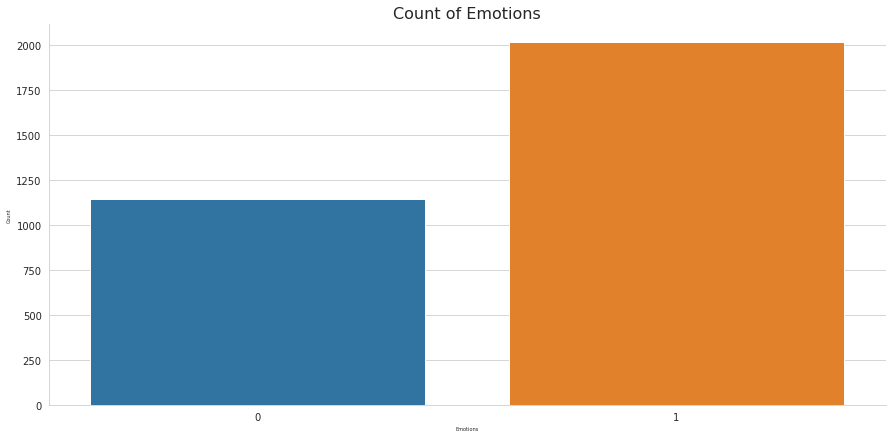

In [102]:
plt.figure(figsize=(15,7))
plt.title('Count of Emotions', size=16)
sns.countplot(y_train)
plt.ylabel('Count', size=5)
plt.xlabel('Emotions', size=5)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show

## Feature Extraction

In [100]:
X_train, y_train, X_val, y_val, X_test, y_test = feature_extractor(df_train, df_val, df_test, 26)

100%|███████████████████████████████████████| 1700/1700 [00:25<00:00, 67.96it/s]


In [101]:
y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)

In [258]:
np.size(y_test)

1700

In [259]:
X_train, X_val, X_test = standard_scaling(X_train, X_val, X_test)

In [ ]:
X_train.shape

## Shuffle training data

In [261]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

## Hypeparameter optimization

In [262]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1)

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [263]:
%%time

# set reproducibility 
seed = 7
np.random.seed(seed)

batch_size = 4
epochs = 50

model_CV = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=2)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'glorot_uniform', 'glorot_normal', 'he_normal', 'he_uniform']
batches = [4,8,16]
lr = [0.001, 0.0001, 0.00005]

param_grid = dict(init_mode=init_mode, lr = lr, batch_size = batches)
grid = RandomizedSearchCV(estimator=model_CV, param_distributions=param_grid, n_jobs=-1, cv=KFold(3))
#grid_result = grid.fit(X_train, y_train, callbacks=[reduce_lr, early_stop], class_weight = class_weights)
grid_result =  grid.fit(X_train, y_train,class_weight = class_weights)

2021-09-10 15:38:14.020623: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-10 15:38:14.020856: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-10 15:38:14.137895: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-10 15:38:14.138037: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-10 15:38:14.145236: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

Epoch 1/50
264/264 - 11s - loss: 0.7044 - accuracy: 0.6383
Epoch 1/50
264/264 - 11s - loss: 1.1751 - accuracy: 0.5418
Epoch 1/50
264/264 - 11s - loss: 0.6808 - accuracy: 0.6360
Epoch 1/50
264/264 - 11s - loss: 0.7118 - accuracy: 0.6477
Epoch 1/50
264/264 - 11s - loss: 2.5962 - accuracy: 0.5430
Epoch 1/50
264/264 - 11s - loss: 1.1999 - accuracy: 0.5577
Epoch 1/50
264/264 - 11s - loss: 3.0316 - accuracy: 0.5446
Epoch 1/50
264/264 - 12s - loss: 1.1374 - accuracy: 0.5354
Epoch 2/50
264/264 - 10s - loss: 0.7462 - accuracy: 0.6320
Epoch 2/50
264/264 - 10s - loss: 0.4880 - accuracy: 0.7293
Epoch 2/50
264/264 - 9s - loss: 1.4910 - accuracy: 0.5952
Epoch 2/50
264/264 - 10s - loss: 0.4605 - accuracy: 0.7584
Epoch 2/50
264/264 - 10s - loss: 0.4973 - accuracy: 0.7262
Epoch 2/50
264/264 - 10s - loss: 0.7989 - accuracy: 0.6184
Epoch 2/50
264/264 - 10s - loss: 1.7941 - accuracy: 0.5907
Epoch 2/50
264/264 - 10s - loss: 0.7626 - accuracy: 0.6213
Epoch 3/50
264/264 - 10s - loss: 0.4389 - accuracy: 0.756

In [265]:
# print results
print(f'Best Accuracy {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy 0.8838609457015991 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
 mean=0.8573, std=0.007544 using {'lr': 0.0001, 'init_mode': 'lecun_uniform', 'batch_size': 8}
 mean=0.8804, std=0.0195 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.8402, std=0.01114 using {'lr': 0.0001, 'init_mode': 'he_uniform', 'batch_size': 8}
 mean=0.8392, std=0.01183 using {'lr': 0.001, 'init_mode': 'he_uniform', 'batch_size': 4}
 mean=0.8839, std=0.01629 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
 mean=0.85, std=0.005385 using {'lr': 5e-05, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.8386, std=0.006913 using {'lr': 5e-05, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.8661, std=0.01482 using {'lr': 0.001, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.882, std=0.01054 using {'lr': 0.0001, 'init_mode': 'glorot_normal', 'batch_size': 4}
 mean=0.8813, std=0.01011 using {'lr': 0.0001, 'init_mode': 'uniform', 'batch_size': 4}

## Train with best parameters

In [266]:
#Best Accuracy 0.8838609457015991 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
def create_model( init_mode='uniform', lr = 0.001):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(157,25), kernel_initializer=init_mode)) # 157
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model

In [267]:
seed = 7
np.random.seed(seed)

In [268]:
model = create_model()

In [269]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [270]:
import datetime, os

In [271]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [272]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

2021-09-10 16:20:46.955187: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-10 16:20:46.955218: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-10 16:20:46.955266: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [273]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1, restore_best_weights = True )

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [274]:
history = model.fit(X_train, y_train, batch_size=8, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, tensorboard_callback], class_weight = class_weights)

Epoch 1/500
 20/395 [>.............................] - ETA: 3s - loss: 1.0719 - accuracy: 0.5520

2021-09-10 16:20:52.484094: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-10 16:20:52.484119: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-10 16:20:52.553089: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-09-10 16:20:52.553900: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-09-10 16:20:52.555184: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210910-162046/train/plugins/profile/2021_09_10_16_20_52
2021-09-10 16:20:52.555946: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20210910-162046/train/plugins/profile/2021_09_10_16_20_52/helemanc-Latitude-5410.trace.json.gz
2021-09-10 16:20:52.557081: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210910-162046/train/plugins/p

395/395 [==============================] - 3s 7ms/step - loss: 0.6983 - accuracy: 0.6316 - val_loss: 0.6516 - val_accuracy: 0.6033
Epoch 2/500
395/395 [==============================] - 2s 6ms/step - loss: 0.4458 - accuracy: 0.7645 - val_loss: 0.6357 - val_accuracy: 0.6133
Epoch 3/500
395/395 [==============================] - 2s 6ms/step - loss: 0.4361 - accuracy: 0.7716 - val_loss: 0.6296 - val_accuracy: 0.6667
Epoch 4/500
395/395 [==============================] - 2s 6ms/step - loss: 0.3744 - accuracy: 0.7999 - val_loss: 0.6197 - val_accuracy: 0.6500
Epoch 5/500
395/395 [==============================] - 2s 6ms/step - loss: 0.3785 - accuracy: 0.7879 - val_loss: 0.6081 - val_accuracy: 0.6267
Epoch 6/500
395/395 [==============================] - 2s 6ms/step - loss: 0.3550 - accuracy: 0.7999 - val_loss: 0.5876 - val_accuracy: 0.6967
Epoch 7/500
395/395 [==============================] - 2s 6ms/step - loss: 0.3534 - accuracy: 0.8004 - val_loss: 0.5783 - val_accuracy: 0.6967
Epoch 8/500

In [275]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 11919), started 4:32:32 ago. (Use '!kill 11919' to kill it.)

In [276]:
model.evaluate(X_test, y_test, batch_size=8)

213/213 [==============================] - 0s 2ms/step - loss: 0.7402 - accuracy: 0.5665


[0.7401905655860901, 0.5664705634117126]

In [277]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.49      0.48      0.48       728
           1       0.62      0.63      0.63       972

    accuracy                           0.57      1700
   macro avg       0.56      0.56      0.56      1700
weighted avg       0.56      0.57      0.57      1700



## Save best model 

In [278]:
model.save("/home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_11")

INFO:tensorflow:Assets written to: /home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_1/model_1_11/assets


# Experiment 3.12:  RAVDESS - TESS - SAVEE - CREMA noise

## Read dataframes

In [331]:
preprocess_path_rav = "/home/helemanc/Desktop/Binary_Model/df_csv_noise/ravdess"
preprocess_path_savee = "/home/helemanc/Desktop/Binary_Model/df_csv_noise/savee"
preprocess_path_tess = "/home/helemanc/Desktop/Binary_Model/df_csv_noise/tess"
preprocess_path_crema = "/home/helemanc/Desktop/Binary_Model/df_csv_noise/crema"

df_train_rav = pd.read_csv(os.path.join(preprocess_path_rav,"df_train.csv"))
df_val_rav = pd.read_csv(os.path.join(preprocess_path_rav,"df_val.csv"))
df_test_rav = pd.read_csv(os.path.join(preprocess_path_rav,"df_test.csv"))  

df_train_tess = pd.read_csv(os.path.join(preprocess_path_tess,"df_train.csv"))
df_test_tess= pd.read_csv(os.path.join(preprocess_path_tess,"df_test.csv"))  

df_train_savee = pd.read_csv(os.path.join(preprocess_path_savee,"df_train.csv"))
df_val_savee = pd.read_csv(os.path.join(preprocess_path_savee,"df_val.csv"))
df_test_savee = pd.read_csv(os.path.join(preprocess_path_savee,"df_test.csv"))  

df_train_crema = pd.read_csv(os.path.join(preprocess_path_crema,"df_train.csv"))
df_val_crema = pd.read_csv(os.path.join(preprocess_path_crema,"df_val.csv"))
df_test_crema = pd.read_csv(os.path.join(preprocess_path_crema,"df_test.csv")) 

In [332]:
df_train = pd.concat([df_train_rav, df_train_savee, df_train_tess, df_train_crema])
df_val = pd.concat([df_val_rav, df_val_savee, df_train_crema, df_train_crema])
#df_test = pd.concat([df_test_rav, df_test_savee, df_test_tess])
#df_test = pd.concat([df_test_rav, df_test_savee, df_test_crema ])
df_test = pd.concat([df_test_rav, df_test_savee ])

In [333]:
df_train.reset_index(drop = True, inplace = True) 
df_val.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

## Feature Extraction

In [334]:
X_train, y_train, X_val, y_val, X_test, y_test = feature_extractor(df_train, df_val, df_test, 26) # 13

100%|█████████████████████████████████████████| 240/240 [00:03<00:00, 74.86it/s]


In [344]:
X_train[0].shape

(157, 12)

In [335]:
y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)

In [336]:
np.size(y_val)

1520

In [337]:
X_train, X_val, X_test = standard_scaling(X_train, X_val, X_test)

In [338]:
X_train.shape

(6320, 157, 12)

## Shuffle training data

In [354]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

## Hypeparameter optimization

In [287]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1)

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [288]:
%%time

# set reproducibility 
seed = 7
np.random.seed(seed)

batch_size = 4
epochs = 50

model_CV = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=2)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'glorot_uniform', 'glorot_normal', 'he_normal', 'he_uniform']
batches = [4,8,16]
lr = [0.001, 0.0001, 0.00005]

param_grid = dict(init_mode=init_mode, lr = lr, batch_size = batches)
grid = RandomizedSearchCV(estimator=model_CV, param_distributions=param_grid, n_jobs=-1, cv=KFold(3))
#grid_result = grid.fit(X_train, y_train, callbacks=[reduce_lr, early_stop], class_weight = class_weights)
grid_result =  grid.fit(X_train, y_train,class_weight = class_weights)

2021-09-13 10:27:30.700024: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-13 10:27:30.700277: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-13 10:27:30.704344: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-13 10:27:30.704344: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-13 10:27:30.704367: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your mac

Epoch 1/50
527/527 - 21s - loss: 0.9913 - accuracy: 0.5374
Epoch 1/50
527/527 - 21s - loss: 2.2675 - accuracy: 0.5775
Epoch 1/50
527/527 - 21s - loss: 0.7146 - accuracy: 0.5830
Epoch 1/50
527/527 - 21s - loss: 0.9287 - accuracy: 0.6205
Epoch 1/50
527/527 - 21s - loss: 0.9860 - accuracy: 0.5529
Epoch 1/50
527/527 - 21s - loss: 0.6703 - accuracy: 0.6082
Epoch 1/50
527/527 - 21s - loss: 2.4049 - accuracy: 0.5267
Epoch 1/50
527/527 - 22s - loss: 0.5606 - accuracy: 0.7202
Epoch 2/50
527/527 - 19s - loss: 0.6043 - accuracy: 0.6357
Epoch 2/50
527/527 - 20s - loss: 1.0160 - accuracy: 0.6492
Epoch 2/50
527/527 - 20s - loss: 0.6938 - accuracy: 0.6082
Epoch 2/50
527/527 - 20s - loss: 0.6962 - accuracy: 0.5917
Epoch 2/50
527/527 - 20s - loss: 0.5403 - accuracy: 0.6837
Epoch 2/50
527/527 - 20s - loss: 0.5865 - accuracy: 0.7040
Epoch 2/50
527/527 - 20s - loss: 1.0992 - accuracy: 0.5616
Epoch 2/50
527/527 - 20s - loss: 0.3999 - accuracy: 0.7985
Epoch 3/50
527/527 - 20s - loss: 0.5527 - accuracy: 0.68

In [289]:
# print results
print(f'Best Accuracy {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy 0.6966690222422282 using {'lr': 0.0001, 'init_mode': 'uniform', 'batch_size': 4}
 mean=0.6429, std=0.1247 using {'lr': 0.0001, 'init_mode': 'lecun_uniform', 'batch_size': 8}
 mean=0.5807, std=0.1364 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.6169, std=0.1255 using {'lr': 0.0001, 'init_mode': 'he_uniform', 'batch_size': 8}
 mean=0.5599, std=0.1689 using {'lr': 0.001, 'init_mode': 'he_uniform', 'batch_size': 4}
 mean=0.6231, std=0.1367 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 8}
 mean=0.6706, std=0.09697 using {'lr': 5e-05, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.625, std=0.1168 using {'lr': 5e-05, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.5778, std=0.1613 using {'lr': 0.001, 'init_mode': 'he_normal', 'batch_size': 8}
 mean=0.6927, std=0.1053 using {'lr': 0.0001, 'init_mode': 'glorot_normal', 'batch_size': 4}
 mean=0.6967, std=0.1012 using {'lr': 0.0001, 'init_mode': 'uniform', 'batch_size': 4}


## Train with best parameters

In [290]:
#Best Accuracy 0.6966690222422282 using {'lr': 0.0001, 'init_mode': 'uniform', 'batch_size': 4}
def create_model( init_mode='uniform', lr = 0.0001):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(157,25), kernel_initializer=init_mode)) # 157, 12
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6)) #0.6

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6)) #0.6

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model

In [291]:
seed = 7
np.random.seed(seed)

In [292]:
model = create_model()

In [293]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [294]:
import datetime, os

In [295]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [296]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

2021-09-13 11:54:08.987049: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-13 11:54:08.987082: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-13 11:54:08.987144: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [298]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1, restore_best_weights = True )

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [299]:
history = model.fit(X_train, y_train, batch_size=4, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, tensorboard_callback], class_weight = class_weights)

Epoch 1/500
  33/1580 [..............................] - ETA: 8s - loss: 0.8216 - accuracy: 0.4616 

2021-09-13 11:54:23.201137: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-13 11:54:23.201163: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-13 11:54:23.256401: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-09-13 11:54:23.257183: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-09-13 11:54:23.258468: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210913-115408/train/plugins/profile/2021_09_13_11_54_23
2021-09-13 11:54:23.259187: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20210913-115408/train/plugins/profile/2021_09_13_11_54_23/helemanc-Latitude-5410.trace.json.gz
2021-09-13 11:54:23.260289: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210913-115408/train/plugins/p

1580/1580 [==============================] - 7s 4ms/step - loss: 0.7010 - accuracy: 0.5617 - val_loss: 0.6454 - val_accuracy: 0.6770
Epoch 2/500
1580/1580 [==============================] - 6s 4ms/step - loss: 0.5629 - accuracy: 0.6848 - val_loss: 0.6152 - val_accuracy: 0.7408
Epoch 3/500
1580/1580 [==============================] - 6s 4ms/step - loss: 0.5055 - accuracy: 0.7279 - val_loss: 0.5943 - val_accuracy: 0.7546
Epoch 4/500
1580/1580 [==============================] - 6s 4ms/step - loss: 0.4466 - accuracy: 0.7671 - val_loss: 0.5958 - val_accuracy: 0.7250
Epoch 5/500
1580/1580 [==============================] - 6s 4ms/step - loss: 0.4432 - accuracy: 0.7597 - val_loss: 0.5729 - val_accuracy: 0.7697
Epoch 6/500
1580/1580 [==============================] - 6s 4ms/step - loss: 0.4090 - accuracy: 0.7860 - val_loss: 0.5790 - val_accuracy: 0.7500
Epoch 7/500
1580/1580 [==============================] - 6s 4ms/step - loss: 0.4180 - accuracy: 0.7743 - val_loss: 0.6171 - val_accuracy: 0.67

In [300]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 11919), started 3 days, 0:55:29 ago. (Use '!kill 11919' to kill it.)

In [329]:
model.evaluate(X_test, y_test, batch_size=4)

60/60 [==============================] - 0s 1ms/step - loss: 0.5977 - accuracy: 0.6833


[0.59771329164505, 0.6833333373069763]

In [339]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.68      0.65      0.66       116
           1       0.68      0.72      0.70       124

    accuracy                           0.68       240
   macro avg       0.68      0.68      0.68       240
weighted avg       0.68      0.68      0.68       240



## Save best model 

In [310]:
model.save("/home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_3/model_3_12")

INFO:tensorflow:Assets written to: /home/helemanc/Desktop/Binary_Model/models_experiments/Experiment_1/model_1_12/assets
